## Installs and Imports

In [1]:
pip install snowflake-connector-python

In [ ]:
pip install dtw

  Created wheel for dtw: filename=dtw-1.4.0-py3-none-any.whl size=5319 sha256=89febe7e87b764bdcd1b942e38d579016c887788b107163bf067c1cca0d17ba4
  Stored in directory: c:\users\carolloj\appdata\local\pip\cache\wheels\5b\cc\44\62f60769f89e834ab2124c69de4005c771e0ff06af908bbbf3
Successfully built dtw
Note: you may need to restart the kernel to use updated packages.


In [9]:
!pip install pandas-profiling==2.7.1

In [7]:
pip install pyarrow==5.0.0 --user

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns
import mitosheet
import talib
from talib import MA_Type, RSI, BBANDS
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as pyplot
from scipy.signal import freqz

In [3]:
import getpass

pwd = getpass.getpass("Enter Password")

Enter Password ·········


In [4]:
import snowflake.connector
conn = snowflake.connector.connect(user='jcarollo', password=str(pwd),account='kga72450.us-east-1')

Snowflake Connector for Python Version: 2.7.1, Python Version: 3.8.5, Platform: Windows-10-10.0.18362-SP0
This connection is in OCSP Fail Open Mode. TLS Certificates would be checked for validity and revocation status. Any other Certificate Revocation related exceptions or OCSP Responder failures would be disregarded in favor of connectivity.
Setting use_openssl_only mode to False


## Pulling Data

In [5]:
sql = """
SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE, CAST(HIGH as float) as High, CAST(LOW as float) as Low
    , CAST((High - Low) as float) as SPREAD, CAST(Volume as float) as Volume, CAST(number_of_trades as float) as number_of_trades, COIN
     -- DATE(OPEN_TIME) Date_Open, TIME(OPEN_TIME) Time_Open,  TO_TIMESTAMP("CLOSE TIME") as CLOSE_TIMESTAMP, DATE("CLOSE TIME") Date_Close, TIME("CLOSE TIME") Time_Close, quote_asset_volume, taker_buy_base_asset, takery_buy_quote_asset_volume
from "CRYPTO"."PUBLIC"."TOP_CRYPTO_YTD"
WHERE DATE(OPEN_TIME) BETWEEN '2021-11-01'AND '2021-11-18' 
ORDER BY OPEN_TIMESTAMP desc

"""

In [6]:
res = conn.cursor().execute(sql).fetchall()

query: [SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE,...]
query execution done


In [7]:
df = pd.read_sql(sql,conn)
df.info()

query: [SELECT TO_TIMESTAMP(OPEN_TIME) as OPEN_TIMESTAMP, CAST(CLOSE as float) as CLOSE,...]
query execution done


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OPEN_TIMESTAMP    362880 non-null  datetime64[ns]
 1   CLOSE             362880 non-null  float64       
 2   HIGH              362880 non-null  float64       
 3   LOW               362880 non-null  float64       
 4   SPREAD            362880 non-null  float64       
 5   VOLUME            362880 non-null  float64       
 6   NUMBER_OF_TRADES  362880 non-null  float64       
 7   COIN              362880 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.1+ MB


## EDA

In [8]:
df.shape

(362880, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 362880 entries, 0 to 362879
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   OPEN_TIMESTAMP    362880 non-null  datetime64[ns]
 1   CLOSE             362880 non-null  float64       
 2   HIGH              362880 non-null  float64       
 3   LOW               362880 non-null  float64       
 4   SPREAD            362880 non-null  float64       
 5   VOLUME            362880 non-null  float64       
 6   NUMBER_OF_TRADES  362880 non-null  float64       
 7   COIN              362880 non-null  object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 22.1+ MB


In [10]:
df.head()

,OPEN_TIMESTAMP,CLOSE,HIGH,LOW,SPREAD,VOLUME,NUMBER_OF_TRADES,COIN
0,2021-11-18 23:59:00,56891.6200,56985.7300,56865.5700,120.1600,31.51592,1000.0,BTCUSDT
1,2021-11-18 23:59:00,1.8477,1.8534,1.8453,0.0081,58710.00000,227.0,FTMUSDT
2,2021-11-18 23:59:00,0.4298,0.4317,0.4296,0.0021,201977.00000,170.0,CHZUSDT
3,2021-11-18 23:59:00,195.0100,195.5000,194.9400,0.5600,2501.90000,297.0,SOLUSDT
4,2021-11-18 23:59:00,100.6300,101.1100,100.0700,1.0400,16711.21000,5034.0,AVAXUSDT


In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CLOSE,362880.0,4858.073486,16199.326532,0.07458,1.5800,3.0528,87.70,69000.0
HIGH,362880.0,4860.659535,16207.796327,0.07525,1.5830,3.0580,87.80,69000.0
LOW,362880.0,4855.423127,16190.637241,0.07400,1.5780,3.0480,87.61,68786.7
SPREAD,362880.0,5.236407,23.321566,0.00000,0.0030,0.0130,0.18,2102.2
VOLUME,362880.0,137252.543559,720505.072526,0.00000,1446.2575,12795.8000,70440.00,70561874.0
NUMBER_OF_TRADES,362880.0,553.784538,1212.987900,0.00000,110.0000,257.0000,576.00,55181.0


In [12]:
# Checking for nulls. None present.

df.isnull().sum()

OPEN_TIMESTAMP      0
CLOSE               0
HIGH                0
LOW                 0
SPREAD              0
VOLUME              0
NUMBER_OF_TRADES    0
COIN                0
dtype: int64

In [13]:
# Cross-tabbing for wide data.

df_pivot = pd.pivot_table(df, index=['OPEN_TIMESTAMP'], columns = 'COIN').reset_index()
df_pivot.columns = df_pivot.columns.get_level_values(1)+'_'+df_pivot.columns.get_level_values(0)
df_pivot.head()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
0,2021-11-01 00:00:00,64.53,0.9892,61295.43,0.4135,42.78,2.551,4290.45,2.8592,0.09584,...,13461.40,58792.5,502.5403,125332.0,185583.0,3683.94,365117.0,901402.0,182405.8,4398.55
1,2021-11-01 00:01:00,64.30,0.9829,61296.60,0.4090,42.73,2.534,4292.12,2.8519,0.09556,...,12100.04,92428.0,465.5863,225429.0,142841.0,3473.91,148903.0,1336944.0,119427.7,2263.00
2,2021-11-01 00:02:00,64.25,0.9800,61338.99,0.4244,42.70,2.543,4292.09,2.8502,0.09533,...,15855.83,40290.7,450.0697,109769.0,116814.0,7846.87,150511.0,659278.0,144280.9,4419.44
3,2021-11-01 00:03:00,64.13,0.9844,61245.11,0.4297,42.54,2.554,4282.70,2.8398,0.09495,...,28118.79,83285.0,459.5952,122605.0,1035846.0,8604.60,87930.0,463316.0,102133.5,3683.77
4,2021-11-01 00:04:00,64.04,0.9846,61243.62,0.4283,42.62,2.544,4289.74,2.8385,0.09363,...,8204.51,67746.5,338.2213,135539.0,3640765.0,7336.91,98855.0,1154643.0,197516.0,5725.94


In [14]:
# Just having a look

df_pivot.columns

Index(['_OPEN_TIMESTAMP', 'AVAXUSDT_CLOSE', 'BATUSDT_CLOSE', 'BTCUSDT_CLOSE',
       'CHZUSDT_CLOSE', 'DOTUSDT_CLOSE', 'ENJUSDT_CLOSE', 'ETHUSDT_CLOSE',
       'FTMUSDT_CLOSE', 'GALAUSDT_CLOSE', 'LINKUSDT_CLOSE', 'LRCUSDT_CLOSE',
       'MANAUSDT_CLOSE', 'MATICUSDT_CLOSE', 'SOLUSDT_CLOSE', 'AVAXUSDT_HIGH',
       'BATUSDT_HIGH', 'BTCUSDT_HIGH', 'CHZUSDT_HIGH', 'DOTUSDT_HIGH',
       'ENJUSDT_HIGH', 'ETHUSDT_HIGH', 'FTMUSDT_HIGH', 'GALAUSDT_HIGH',
       'LINKUSDT_HIGH', 'LRCUSDT_HIGH', 'MANAUSDT_HIGH', 'MATICUSDT_HIGH',
       'SOLUSDT_HIGH', 'AVAXUSDT_LOW', 'BATUSDT_LOW', 'BTCUSDT_LOW',
       'CHZUSDT_LOW', 'DOTUSDT_LOW', 'ENJUSDT_LOW', 'ETHUSDT_LOW',
       'FTMUSDT_LOW', 'GALAUSDT_LOW', 'LINKUSDT_LOW', 'LRCUSDT_LOW',
       'MANAUSDT_LOW', 'MATICUSDT_LOW', 'SOLUSDT_LOW',
       'AVAXUSDT_NUMBER_OF_TRADES', 'BATUSDT_NUMBER_OF_TRADES',
       'BTCUSDT_NUMBER_OF_TRADES', 'CHZUSDT_NUMBER_OF_TRADES',
       'DOTUSDT_NUMBER_OF_TRADES', 'ENJUSDT_NUMBER_OF_TRADES',
       'ETHUSDT_NUMBER_O

In [15]:
# Just a quick check.

df_pivot.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56844.78,0.4293,38.88,2.995,3988.40,1.8411,0.23110,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.39,0.4296,38.97,3.015,3992.29,1.8448,0.23027,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56877.70,0.4300,39.00,3.019,3993.70,1.8461,0.23153,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.24,0.4313,39.06,3.030,4000.88,1.8505,0.23214,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56891.62,0.4298,39.03,3.042,3996.90,1.8477,0.22883,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


In [17]:
# Just a pull to determine proper rounding.

df_pivot.loc[:,df_pivot.columns.str.endswith('CLOSE')]

,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,LRCUSDT_CLOSE,MANAUSDT_CLOSE,MATICUSDT_CLOSE,SOLUSDT_CLOSE
0,64.53,0.9892,61295.43,0.4135,42.78,2.551,4290.45,2.8592,0.09584,30.02,0.6301,2.8446,1.939,202.87
1,64.30,0.9829,61296.60,0.4090,42.73,2.534,4292.12,2.8519,0.09556,29.99,0.6220,2.7971,1.937,203.05
2,64.25,0.9800,61338.99,0.4244,42.70,2.543,4292.09,2.8502,0.09533,29.97,0.6191,2.8282,1.942,202.87
3,64.13,0.9844,61245.11,0.4297,42.54,2.554,4282.70,2.8398,0.09495,29.86,0.6219,2.8269,1.930,202.43
4,64.04,0.9846,61243.62,0.4283,42.62,2.544,4289.74,2.8385,0.09363,29.89,0.6225,2.9011,1.930,202.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,99.08,0.9736,56844.78,0.4293,38.88,2.995,3988.40,1.8411,0.23110,26.42,2.2114,3.7673,1.490,195.01
25916,99.39,0.9744,56866.39,0.4296,38.97,3.015,3992.29,1.8448,0.23027,26.46,2.2134,3.7827,1.493,195.01
25917,99.70,0.9761,56877.70,0.4300,39.00,3.019,3993.70,1.8461,0.23153,26.48,2.2168,3.7478,1.496,195.25
25918,100.14,0.9781,56937.24,0.4313,39.06,3.030,4000.88,1.8505,0.23214,26.53,2.2165,3.7416,1.498,195.48


In [18]:
# Rounding by column to (hopefully) improve signal processing by reducing variablity when determining frequency of events.

df_pivot['AVAXUSDT_CLOSE']=df_pivot['AVAXUSDT_CLOSE'].round(2)
df_pivot['BATUSDT_CLOSE']=df_pivot['BATUSDT_CLOSE'].round(4)
df_pivot['BTCUSDT_CLOSE']=df_pivot['BTCUSDT_CLOSE'].round(0)
df_pivot['CHZUSDT_CLOSE']=df_pivot['CHZUSDT_CLOSE'].round(4)
df_pivot['DOTUSDT_CLOSE']=df_pivot['DOTUSDT_CLOSE'].round(2)
df_pivot['ENJUSDT_CLOSE']=df_pivot['ENJUSDT_CLOSE'].round(2)
df_pivot['ETHUSDT_CLOSE']=df_pivot['ETHUSDT_CLOSE'].round(0)
df_pivot['FTMUSDT_CLOSE']=df_pivot['FTMUSDT_CLOSE'].round(2)
df_pivot['GALAUSDT_CLOSE']=df_pivot['GALAUSDT_CLOSE'].round(4)
df_pivot['LINKUSDT_CLOSE']=df_pivot['LINKUSDT_CLOSE'].round(2)
df_pivot['LRCUSDT_CLOSE']=df_pivot['LRCUSDT_CLOSE'].round(4)
df_pivot['MANAUSDT_CLOSE']=df_pivot['MANAUSDT_CLOSE'].round(2)
df_pivot['MATICUSDT_CLOSE']=df_pivot['MATICUSDT_CLOSE'].round(2)
df_pivot['SOLUSDT_CLOSE']=df_pivot['SOLUSDT_CLOSE'].round(0)
df_pivot

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
0,2021-11-01 00:00:00,64.53,0.9892,61295.0,0.4135,42.78,2.55,4290.0,2.86,0.0958,...,13461.40,58792.5,502.5403,125332.0,185583.0,3683.94,365117.0,901402.0,182405.8,4398.55
1,2021-11-01 00:01:00,64.30,0.9829,61297.0,0.4090,42.73,2.53,4292.0,2.85,0.0956,...,12100.04,92428.0,465.5863,225429.0,142841.0,3473.91,148903.0,1336944.0,119427.7,2263.00
2,2021-11-01 00:02:00,64.25,0.9800,61339.0,0.4244,42.70,2.54,4292.0,2.85,0.0953,...,15855.83,40290.7,450.0697,109769.0,116814.0,7846.87,150511.0,659278.0,144280.9,4419.44
3,2021-11-01 00:03:00,64.13,0.9844,61245.0,0.4297,42.54,2.55,4283.0,2.84,0.0950,...,28118.79,83285.0,459.5952,122605.0,1035846.0,8604.60,87930.0,463316.0,102133.5,3683.77
4,2021-11-01 00:04:00,64.04,0.9846,61244.0,0.4283,42.62,2.54,4290.0,2.84,0.0936,...,8204.51,67746.5,338.2213,135539.0,3640765.0,7336.91,98855.0,1154643.0,197516.0,5725.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29


In [19]:
# Checking rounding.

df_pivot.iloc[-1:,:15]

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,LRCUSDT_CLOSE,MANAUSDT_CLOSE,MATICUSDT_CLOSE,SOLUSDT_CLOSE
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,26.55,2.2129,3.75,1.49,195.0


In [20]:
# Just a quick check.

df_pivot.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


In [21]:
import warnings
warnings.filterwarnings('ignore')

In [22]:
sns.set(rc={'figure.figsize':(12,8)})

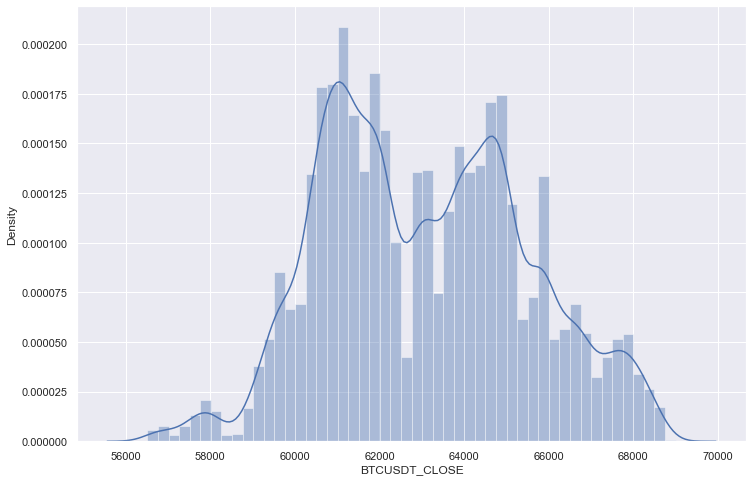

In [23]:
# Just having a look.

sns.distplot(df_pivot['BTCUSDT_CLOSE'])
plt.show()

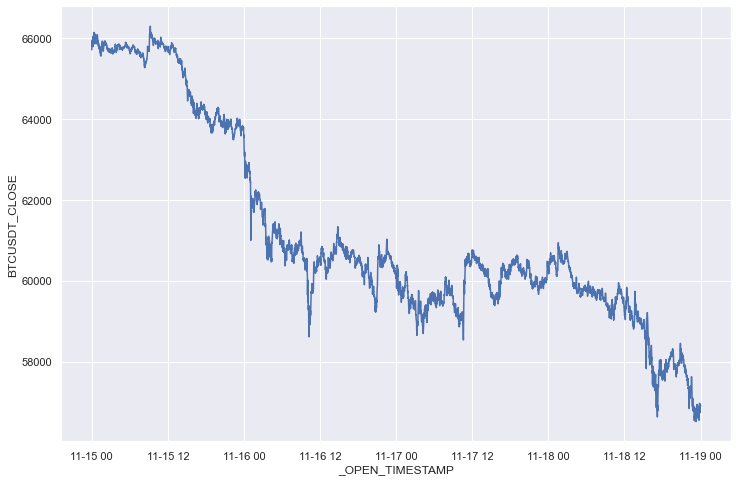

In [24]:
# Just having a look.

sns.lineplot(x="_OPEN_TIMESTAMP", y="BTCUSDT_CLOSE", data=df_pivot.query('_OPEN_TIMESTAMP >= "2021-11-15"'))
plt.show()

In [25]:
# Filtering pivoted day to most recent 3 days.

df_pivot_filtered = df_pivot.iloc[-4320:]
df_pivot_filtered.shape

(4320, 85)

In [26]:
# Just checking it out.

df_pivot_filtered.tail()

,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,DOTUSDT_VOLUME,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME
25915,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,3490.81,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87
25916,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,3445.58,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77
25917,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,10809.06,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34
25918,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,3000.74,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29
25919,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,8347.22,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90


## SweetViz

In [ ]:
# Create an amazing report describing the dataframe. Find this file by expand the left pane and clicking on the folder icon. This is perfect for sharing!
from pandas_profiling import ProfileReport
profile = ProfileReport(df_pivot_filtered)
profile.to_file(output_file='PandasProfiling_df_pivot_filtered.html')

## Analyzing Pearson's Correlation

In [27]:
# Dataframe of only close prices for analysis

df_close = df_pivot_filtered.loc[:,df_pivot_filtered.columns.str.endswith('CLOSE')]
df_close.columns

Index(['AVAXUSDT_CLOSE', 'BATUSDT_CLOSE', 'BTCUSDT_CLOSE', 'CHZUSDT_CLOSE',
       'DOTUSDT_CLOSE', 'ENJUSDT_CLOSE', 'ETHUSDT_CLOSE', 'FTMUSDT_CLOSE',
       'GALAUSDT_CLOSE', 'LINKUSDT_CLOSE', 'LRCUSDT_CLOSE', 'MANAUSDT_CLOSE',
       'MATICUSDT_CLOSE', 'SOLUSDT_CLOSE'],
      dtype='object')

In [28]:
# Checking for nulls. None present.

df_close.isnull().sum()

AVAXUSDT_CLOSE     0
BATUSDT_CLOSE      0
BTCUSDT_CLOSE      0
CHZUSDT_CLOSE      0
DOTUSDT_CLOSE      0
ENJUSDT_CLOSE      0
ETHUSDT_CLOSE      0
FTMUSDT_CLOSE      0
GALAUSDT_CLOSE     0
LINKUSDT_CLOSE     0
LRCUSDT_CLOSE      0
MANAUSDT_CLOSE     0
MATICUSDT_CLOSE    0
SOLUSDT_CLOSE      0
dtype: int64

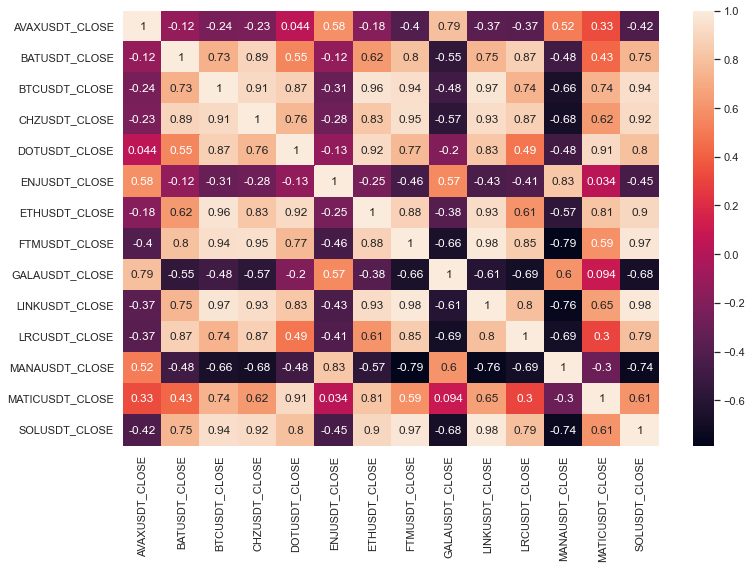

In [29]:
# Correlationon filtered data.

corrMatrix = df_close.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [30]:
# Convert correlation matrix to 1-D Series and sort

sorted_corrmat = pd.DataFrame(corrMatrix.unstack(),columns= {'Correlation'})
print(sorted_corrmat.shape)
sorted_corrmat.head()

(196, 1)


Correlation
AVAXUSDT_CLOSE AVAXUSDT_CLOSE     1.000000
               BATUSDT_CLOSE     -0.119873
               BTCUSDT_CLOSE     -0.239913
               CHZUSDT_CLOSE     -0.231108
               DOTUSDT_CLOSE      0.043790

In [31]:
# Checking for nulls. None present.

sorted_corrmat.isnull().sum()

Correlation    0
dtype: int64

In [32]:
# Filter out 1's.
# Duplicate correlations present
sorted_corrmat = sorted_corrmat[sorted_corrmat.Correlation < 1].sort_values('Correlation', ascending=False)
sorted_corrmat.drop_duplicates(keep='first', inplace=True)
print(sorted_corrmat.shape)
sorted_corrmat.head(10)

(91, 1)


Correlation
FTMUSDT_CLOSE  LINKUSDT_CLOSE     0.980891
SOLUSDT_CLOSE  LINKUSDT_CLOSE     0.979190
FTMUSDT_CLOSE  SOLUSDT_CLOSE      0.973788
BTCUSDT_CLOSE  LINKUSDT_CLOSE     0.968758
               ETHUSDT_CLOSE      0.961841
CHZUSDT_CLOSE  FTMUSDT_CLOSE      0.949467
BTCUSDT_CLOSE  SOLUSDT_CLOSE      0.937248
               FTMUSDT_CLOSE      0.937218
CHZUSDT_CLOSE  LINKUSDT_CLOSE     0.932973
LINKUSDT_CLOSE ETHUSDT_CLOSE      0.926161

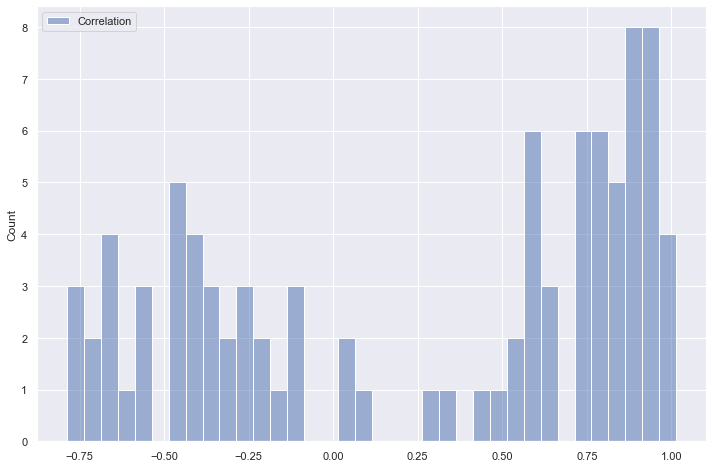

In [33]:
# Having a look at the distribution of the correlations.

sns.histplot(sorted_corrmat, binwidth=0.05)
plt.show()

In [34]:
# Top positively correlated coins.

sorted_corrmat_high = pd.DataFrame(sorted_corrmat[sorted_corrmat.Correlation > 0.90].sort_values('Correlation', ascending=False))
sorted_corrmat_high.reset_index(inplace=True)
print(sorted_corrmat_high.shape)
print(sorted_corrmat_high)

(15, 3)
           level_0          level_1  Correlation
0    FTMUSDT_CLOSE   LINKUSDT_CLOSE     0.980891
1    SOLUSDT_CLOSE   LINKUSDT_CLOSE     0.979190
2    FTMUSDT_CLOSE    SOLUSDT_CLOSE     0.973788
3    BTCUSDT_CLOSE   LINKUSDT_CLOSE     0.968758
4    BTCUSDT_CLOSE    ETHUSDT_CLOSE     0.961841
5    CHZUSDT_CLOSE    FTMUSDT_CLOSE     0.949467
6    BTCUSDT_CLOSE    SOLUSDT_CLOSE     0.937248
7    BTCUSDT_CLOSE    FTMUSDT_CLOSE     0.937218
8    CHZUSDT_CLOSE   LINKUSDT_CLOSE     0.932973
9   LINKUSDT_CLOSE    ETHUSDT_CLOSE     0.926161
10   SOLUSDT_CLOSE    CHZUSDT_CLOSE     0.922969
11   ETHUSDT_CLOSE    DOTUSDT_CLOSE     0.918805
12   DOTUSDT_CLOSE  MATICUSDT_CLOSE     0.913340
13   BTCUSDT_CLOSE    CHZUSDT_CLOSE     0.912415
14   ETHUSDT_CLOSE    SOLUSDT_CLOSE     0.904877


In [35]:
# Assembling high correlation coins

df_high0 = pd.DataFrame(df_close[sorted_corrmat_high['level_0'].unique()])
df_high0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 21600 to 25919
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FTMUSDT_CLOSE   4320 non-null   float64
 1   SOLUSDT_CLOSE   4320 non-null   float64
 2   BTCUSDT_CLOSE   4320 non-null   float64
 3   CHZUSDT_CLOSE   4320 non-null   float64
 4   LINKUSDT_CLOSE  4320 non-null   float64
 5   ETHUSDT_CLOSE   4320 non-null   float64
 6   DOTUSDT_CLOSE   4320 non-null   float64
dtypes: float64(7)
memory usage: 236.4 KB


In [37]:
# Assembling high correlation coins

df_high1 = pd.DataFrame(df_close[sorted_corrmat_high['level_1'].unique()])
df_high1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 21600 to 25919
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   LINKUSDT_CLOSE   4320 non-null   float64
 1   SOLUSDT_CLOSE    4320 non-null   float64
 2   ETHUSDT_CLOSE    4320 non-null   float64
 3   FTMUSDT_CLOSE    4320 non-null   float64
 4   CHZUSDT_CLOSE    4320 non-null   float64
 5   DOTUSDT_CLOSE    4320 non-null   float64
 6   MATICUSDT_CLOSE  4320 non-null   float64
dtypes: float64(7)
memory usage: 236.4 KB


In [38]:
# Assembling high correlation coins

df_high = pd.concat([df_high0, df_high1], axis=1).reset_index(drop=True).drop_duplicates()
df_high = df_high.loc[:,~df_high.columns.duplicated()]
print(df_high.shape)
df_high.head()

(4320, 8)


,FTMUSDT_CLOSE,SOLUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,LINKUSDT_CLOSE,ETHUSDT_CLOSE,DOTUSDT_CLOSE,MATICUSDT_CLOSE
0,2.46,237.0,63432.0,0.5318,32.00,4554.0,44.67,1.69
1,2.46,237.0,63340.0,0.5306,31.90,4546.0,44.59,1.68
2,2.46,237.0,63228.0,0.5285,31.72,4541.0,44.48,1.68
3,2.45,237.0,63148.0,0.5273,31.64,4534.0,44.34,1.67
4,2.45,236.0,63091.0,0.5251,31.53,4530.0,44.30,1.67


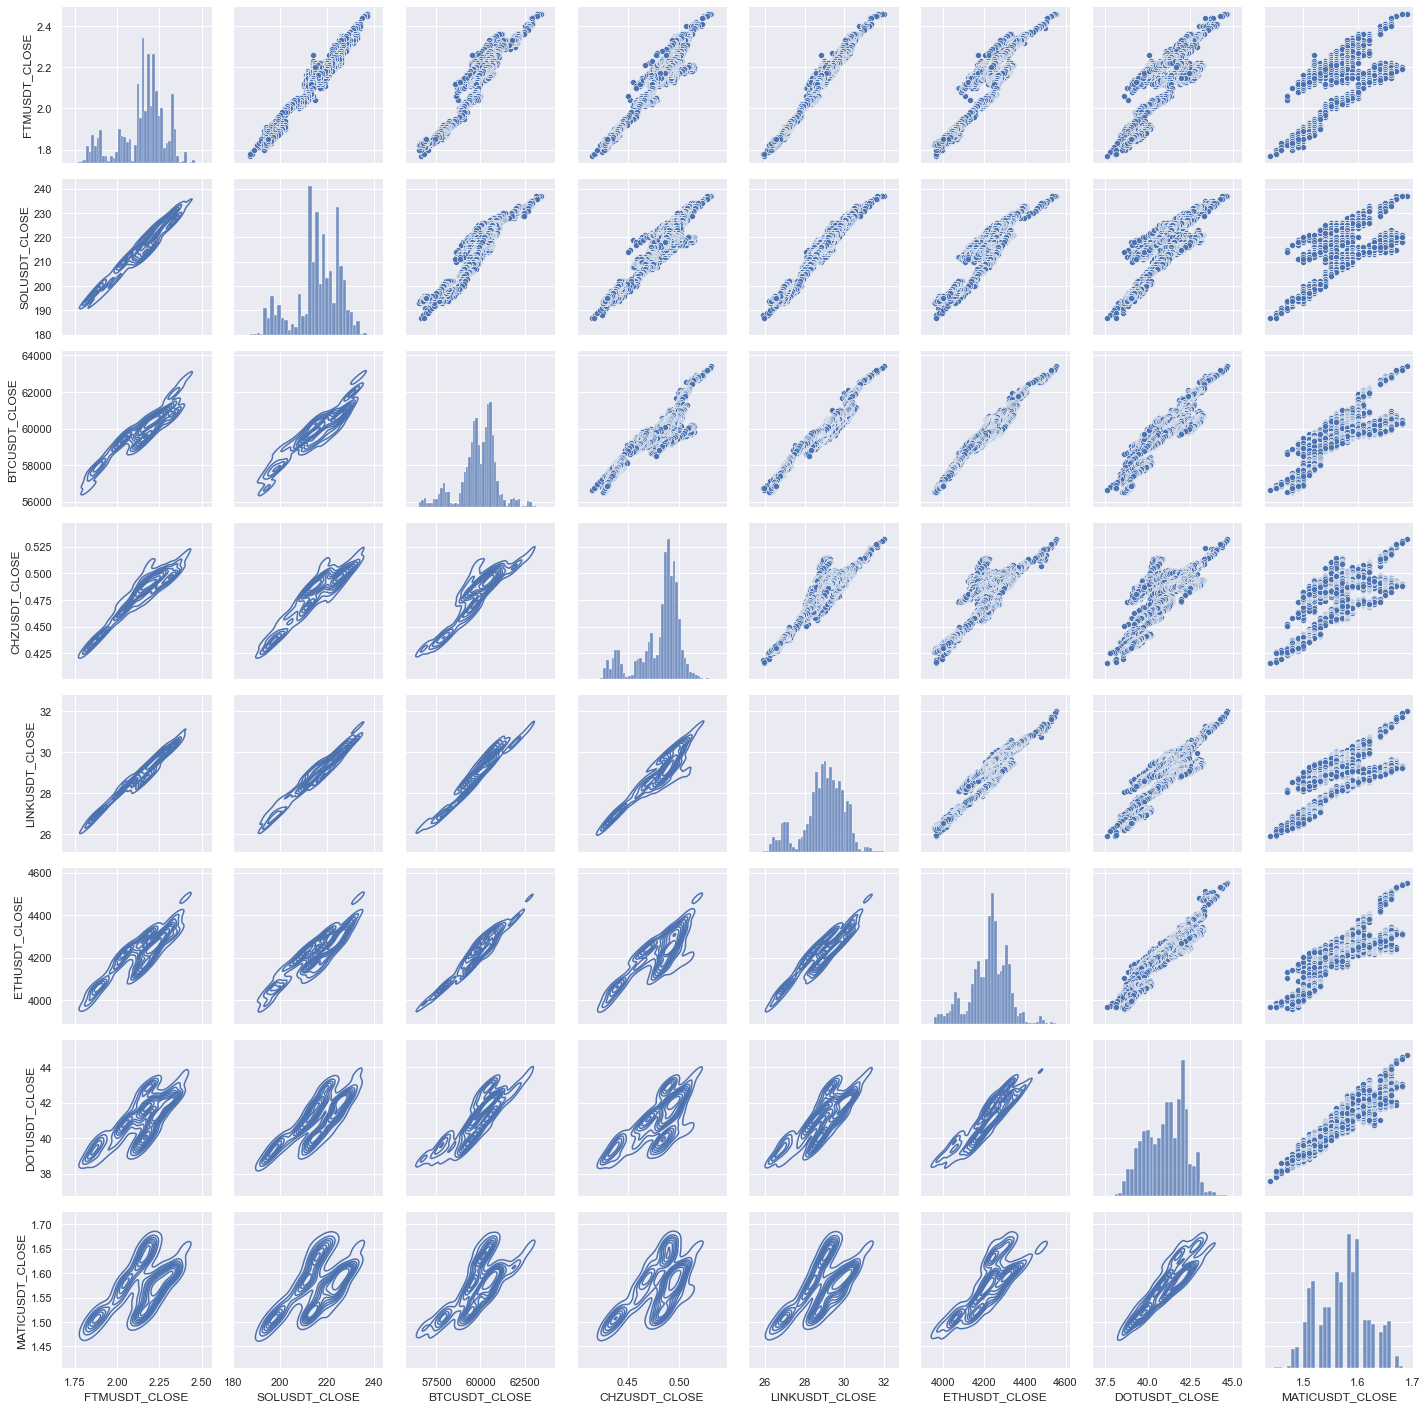

In [39]:
# Having a look at highly correlated coins

g = sns.PairGrid(df_high)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
plt.show()

In [40]:
# Top negatively correlated coins.

sorted_corrmat_low = pd.DataFrame(sorted_corrmat[sorted_corrmat.Correlation < -0.65].sort_values('Correlation', ascending=True))
sorted_corrmat_low.reset_index(inplace=True)
print(sorted_corrmat_low.shape)
print(sorted_corrmat_low)

(9, 3)
          level_0         level_1  Correlation
0  MANAUSDT_CLOSE   FTMUSDT_CLOSE    -0.786267
1  LINKUSDT_CLOSE  MANAUSDT_CLOSE    -0.756814
2  MANAUSDT_CLOSE   SOLUSDT_CLOSE    -0.743023
3  GALAUSDT_CLOSE   LRCUSDT_CLOSE    -0.693271
4   LRCUSDT_CLOSE  MANAUSDT_CLOSE    -0.690210
5   CHZUSDT_CLOSE  MANAUSDT_CLOSE    -0.681865
6  GALAUSDT_CLOSE   SOLUSDT_CLOSE    -0.679556
7   BTCUSDT_CLOSE  MANAUSDT_CLOSE    -0.660695
8  GALAUSDT_CLOSE   FTMUSDT_CLOSE    -0.657398


In [41]:
# Assembling low correlation coins

df_low0 = pd.DataFrame(df_close[sorted_corrmat_low['level_0'].unique()])
df_low0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 21600 to 25919
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MANAUSDT_CLOSE  4320 non-null   float64
 1   LINKUSDT_CLOSE  4320 non-null   float64
 2   GALAUSDT_CLOSE  4320 non-null   float64
 3   LRCUSDT_CLOSE   4320 non-null   float64
 4   CHZUSDT_CLOSE   4320 non-null   float64
 5   BTCUSDT_CLOSE   4320 non-null   float64
dtypes: float64(6)
memory usage: 202.6 KB


In [42]:
# Assembling low correlation coins

df_low1 = pd.DataFrame(df_close[sorted_corrmat_low['level_1'].unique()])
df_low1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 21600 to 25919
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FTMUSDT_CLOSE   4320 non-null   float64
 1   MANAUSDT_CLOSE  4320 non-null   float64
 2   SOLUSDT_CLOSE   4320 non-null   float64
 3   LRCUSDT_CLOSE   4320 non-null   float64
dtypes: float64(4)
memory usage: 135.1 KB


In [43]:
# Assembling low correlation coins

df_low = pd.concat([df_low0, df_low1], axis=1).reset_index(drop=True).drop_duplicates()
df_low = df_low.loc[:,~df_low.columns.duplicated()]
print(df_low.shape)
df_low.head()

(4320, 8)


,MANAUSDT_CLOSE,LINKUSDT_CLOSE,GALAUSDT_CLOSE,LRCUSDT_CLOSE,CHZUSDT_CLOSE,BTCUSDT_CLOSE,FTMUSDT_CLOSE,SOLUSDT_CLOSE
0,3.26,32.00,0.1272,2.8962,0.5318,63432.0,2.46,237.0
1,3.27,31.90,0.1291,2.8760,0.5306,63340.0,2.46,237.0
2,3.22,31.72,0.1291,2.8788,0.5285,63228.0,2.46,237.0
3,3.24,31.64,0.1286,2.8813,0.5273,63148.0,2.45,237.0
4,3.23,31.53,0.1271,2.8761,0.5251,63091.0,2.45,236.0


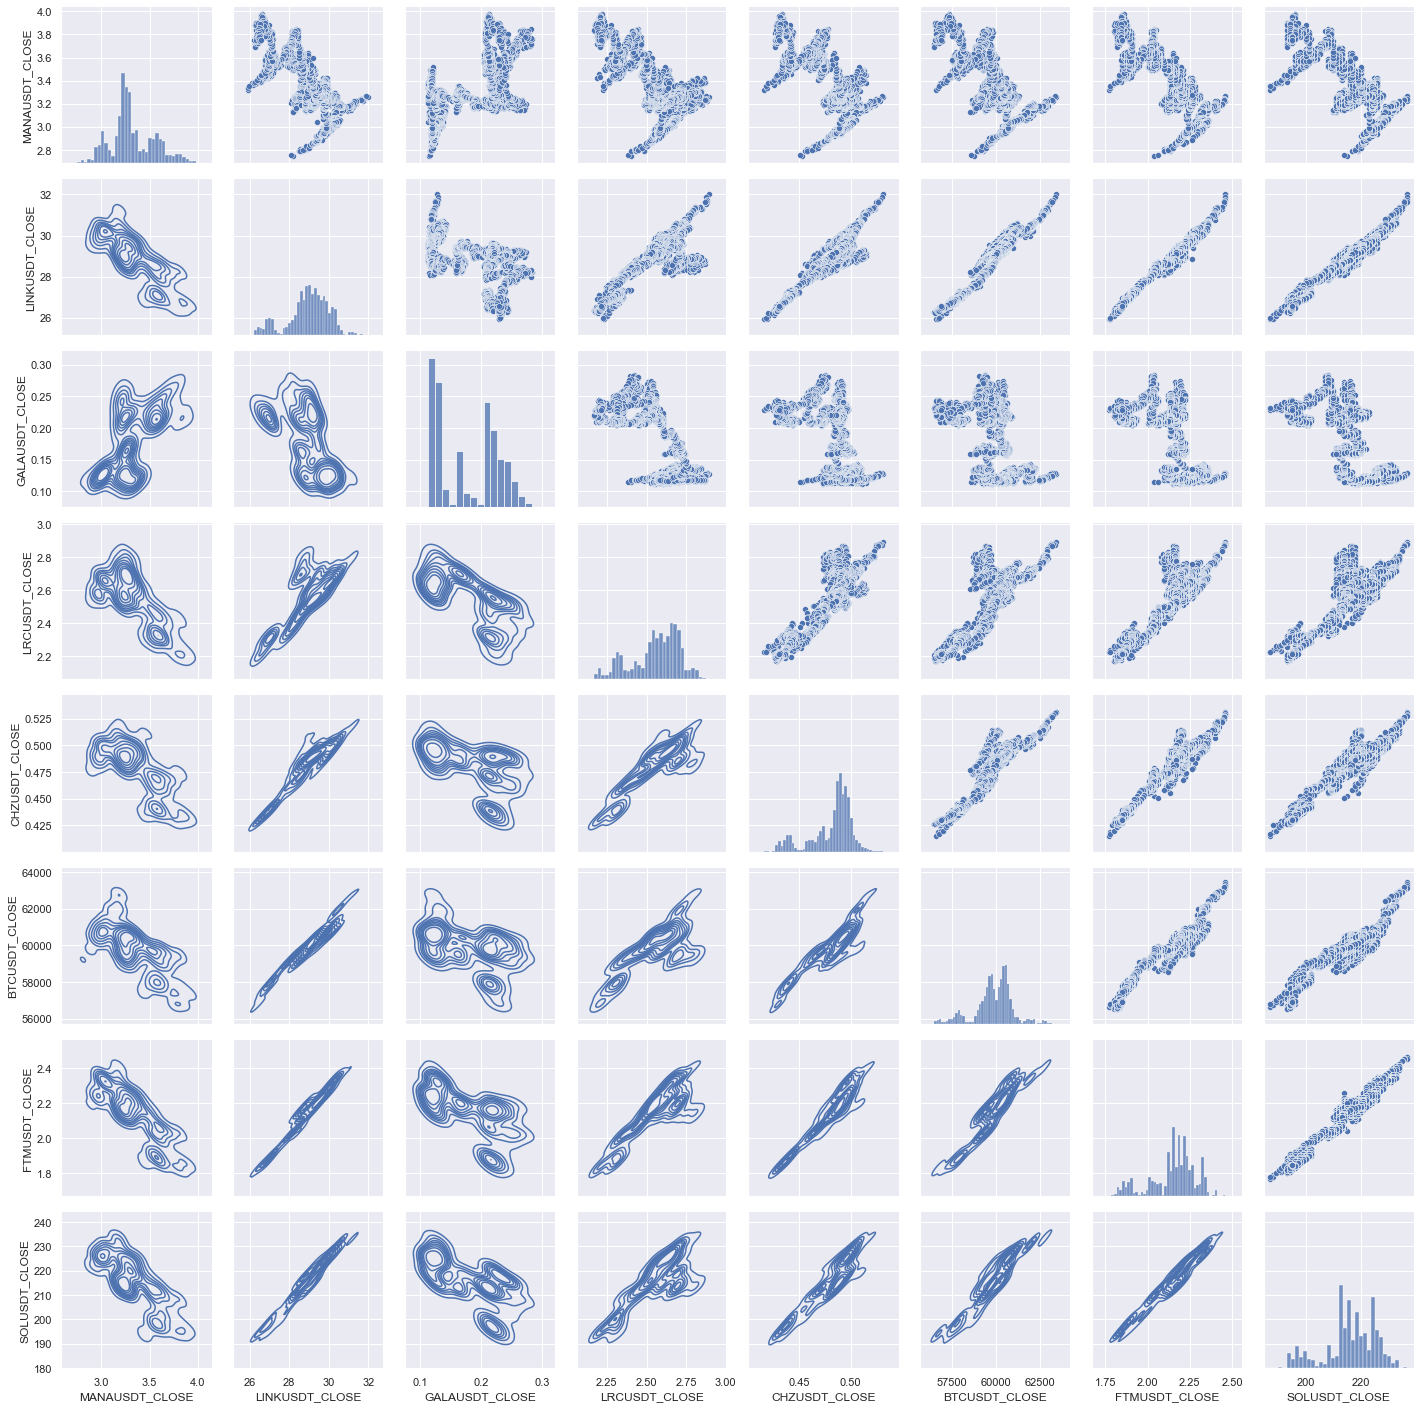

In [44]:
# Having a look at low correlated coins

g = sns.PairGrid(df_low)
g.map_upper(sns.scatterplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.histplot)
plt.show()

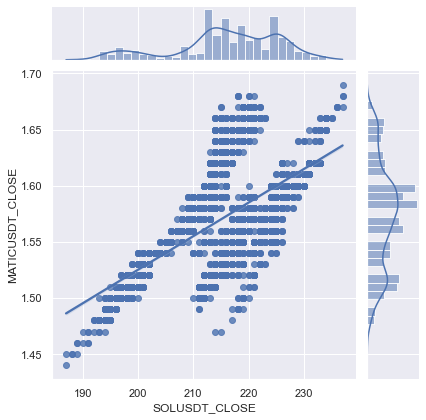

In [45]:
# Looking at correlation and distribution

plt.show(sns.jointplot(data=df_close, x="SOLUSDT_CLOSE", y="MATICUSDT_CLOSE", kind="reg"))

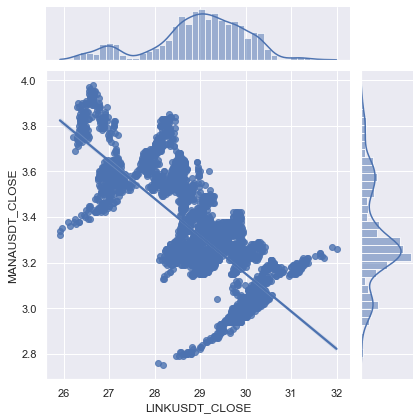

In [46]:
# Looking at correlation and distribution

plt.show(sns.jointplot(data=df_close, x="LINKUSDT_CLOSE", y="MANAUSDT_CLOSE", kind="reg"))

## Signal Processing

https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

https://jinhyuncheong.com/jekyll/update/2017/12/10/Timeseries_synchrony_tutorial_and_simulations.html

In [589]:
# Filteirng dataframe down to the most recent half day

df_close = df_close[int(-(1440/2)):]
df_close.shape

(720, 14)

In [590]:
from scipy.signal import butter, lfilter, filtfilt

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_sp_coin(coin):

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
    lowcut = 10 # Fl in screenshot below
    highcut = 50 # Fh in screenshot below

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [6]: #add more numbers to the list to determine cuts
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')
    plt.title("Frequency Graph")

    # Filter a noisy signal.
    T = 0.05
    nsamples = int(T * fs)
    t = np.linspace(0, T, nsamples, endpoint=False)
    a = 0.02
    f0 = 600.0 # This determines the Hz...see legend in second chart
   
    plt.figure(2)
        
    # Plot the signal
    y = butter_bandpass_filter(df_close[coin], lowcut, highcut, fs, order=6)
    y2 = butter_highpass_filter(df_close[coin], highcut, fs, order=6)
    y3 = butter_lowpass_filter(df_close[coin], lowcut, fs, order=6)
    
    plt.plot(range(df_close.shape[0]), y3, label='Low Frequency (%g Hz)' % f0)
    plt.plot(range(df_close.shape[0]),df_close[coin], label='Original')
    plt.xlabel('time (minutes)')
    plt.legend(loc='best')
    plt.title("Original & Low")
    
    plt.figure(3)
    
    plt.plot(range(df_close.shape[0]), y, c='black', label='Filtered signal (%g Hz)' % f0)
    plt.plot(range(df_close.shape[0]), y2, c='cyan', label='High Frequency (%g Hz)' % f0)
    plt.xlabel('time (minutes)')
    plt.legend(loc='best')
    #plt.hlines([-a, a], 0, (1440/2), linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.title("Signal & High")
    
    plt.legend(loc='best')
    plt.show()

SOLUSDT_CLOSE


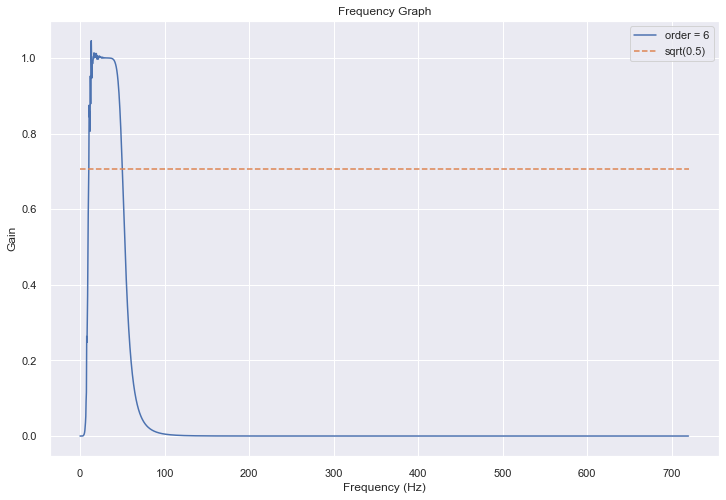

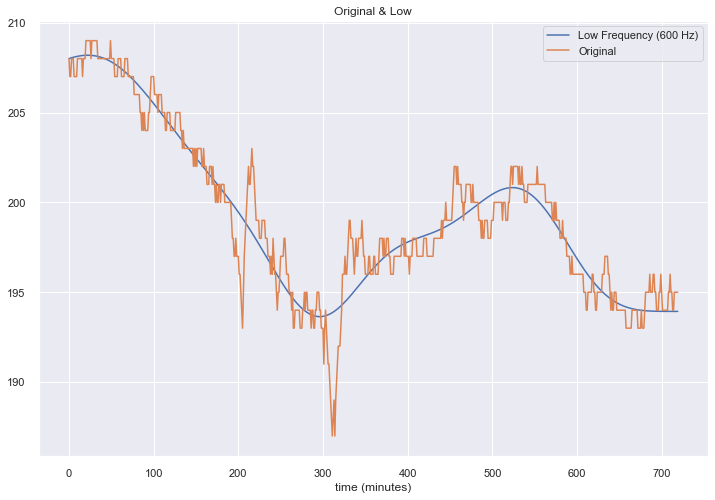

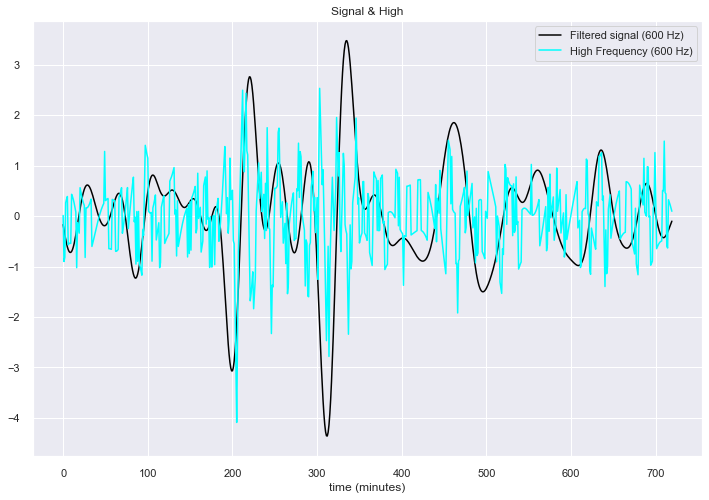

In [603]:
# Top chart signifies cutoff of low frequency, bandpass, and high frequency.
# Middle chart shows low frequency compared with original price. LF is majority of price, and most likely contains the mean price.
# Bottom chart high frequency and bandpass (aka signal).

for coin in ['SOLUSDT_CLOSE']:
#for coin in df_close:
    print(coin)
    plot_sp_coin(coin)

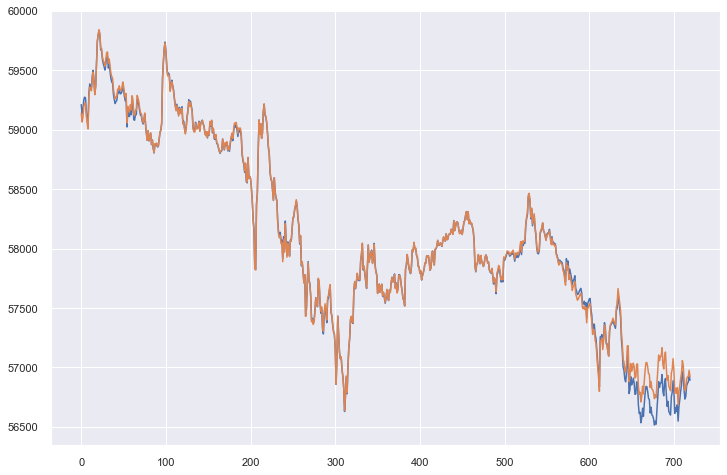

In [592]:
# Adding up low, mid, high frequencies to ensure they sum up to the org price.
# Close enough.

plt.plot(range(df_close.shape[0]),df_close['BTCUSDT_CLOSE'])
plt.plot(range(df_close.shape[0]),y + y2 + y3)
plt.show()

In [593]:
# Constructing a dataframe to double check the math adds up.

df_bbf = pd.DataFrame({"Middle":y, "High":y2, "Low":y3, "Price":df_close['BTCUSDT_CLOSE'].values})
df_bbf['Total'] = (y+y2+y3)
df_bbf['Var_Num'] = (df_close['BTCUSDT_CLOSE'].values - (y+y2+y3) )
df_bbf['Var_Pct'] = (df_close['BTCUSDT_CLOSE'].values / (y+y2+y3) -1 )
df_bbf.tail(25)

,Middle,High,Low,Price,Total,Var_Num,Var_Pct
695,36.321627,-126.463674,56915.214310,56616.0,56825.072263,-209.072263,-0.003679
696,26.213134,-136.592650,56914.936427,56600.0,56804.556911,-204.556911,-0.003601
697,15.766599,23.487081,56914.687722,56755.0,56953.941403,-198.941403,-0.003493
698,5.296457,63.924457,56914.465856,56791.0,56983.686770,-192.686770,-0.003381
699,-4.891475,164.162061,56914.268604,56888.0,57073.539190,-185.539190,-0.003251
...,...,...,...,...,...,...,...
715,-21.206497,12.896048,56913.079968,56845.0,56904.769519,-59.769519,-0.001050
716,-15.817051,22.696652,56913.067237,56866.0,56919.946837,-53.946837,-0.000948
717,-10.620284,22.030255,56913.057072,56878.0,56924.467043,-46.467043,-0.000816
718,-5.753017,69.360516,56913.049043,56937.0,56976.656542,-39.656542,-0.000696


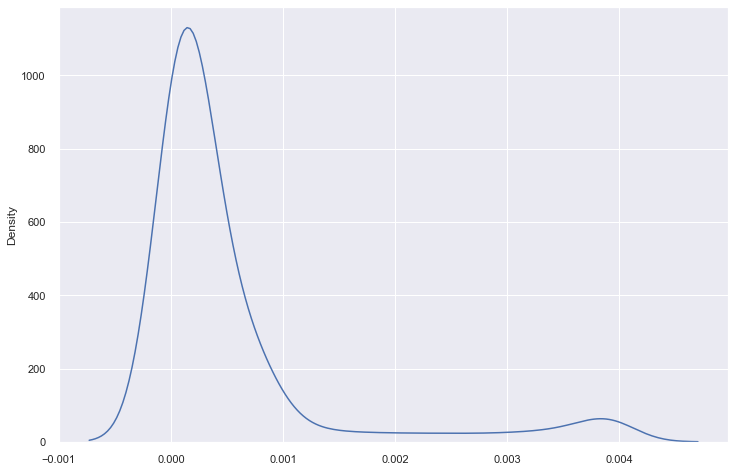

In [594]:
# Nearly all of the price is low frequency.

sns.kdeplot(((df_bbf[["Middle", "High", "Low"]].sum(axis=1) - df_bbf["Price"]).abs()/df_bbf["Price"]))#'.hist()
plt.show()

https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

Design an Nth-order digital or analog Butterworth filter and return the filter coefficients.

For a Butterworth filter, this is the point at which the gain drops to 1/sqrt(2) that of the passband (the “-3 dB point”).

For lowpass and highpass filters, Wn is a scalar; for bandpass and bandstop filters, Wn is a length-2 sequence.

For example, the ID list for item b consists of the following (SID, EID) pairs: {(1, 2), (2, 3), (3, 2), (3, 5), (4, 5)}, 
where the entry (1, 2) means that b occurs in sequence 1, event 2, and so on. Items a and b are frequent. They can
be joined to form the length-2 sequence, (a,b)

A band-pass filter or bandpass filter (BPF) is a device that passes frequencies within a certain range and rejects 

For digital filters, Wn are in the same units as fs. By default, fs is 2 half-cycles/sample, so these are normalized from 0 to 1, where 1 is the Nyquist frequency. (Wn is thus in half-cycles / sample.)

btype{‘lowpass’, ‘highpass’, ‘bandpass’, ‘bandstop’}, optional
The type of filter. Default is ‘lowpass

fsfloat, optional ..... The sampling frequency of the digital system.

https://kevin-kotze.gitlab.io/tsm/ts-6-note/
- Most economic time series exhibit behaviour that is repeated over time. Time series variables is that they may be decomposed into different periodic variations.
- For example, we may wish to extract the cyclical component of the time series, which may be regarded as the part that exhibits higher periodic variation than the trend.
- able to conduct an investigation into the behaviour of the business cycle
- When seeking to decompose a time series into different periodic variations, we could imagine that the process is responding to various driving frequencies that are produced from linear combinations of sine and cosine functions, where each of these sine and cosine functions would represent a different frequency or amplitude. Expressed in these terms, the application of frequency domain techniques may be regarded as a regression of periodic sine and cosines on the respective values of the time series.3

https://en.wikipedia.org/wiki/Frequency
- Frequency is the number of occurrences of a repeating event per unit of time.
- Frequency is measured in hertz (Hz) which is equal to one event per second.
- The period is the duration of time of one cycle in a repeating event, so the period is the reciprocal of the frequency.[2]
- For example, if a heart beats at a frequency of 120 times a minute (2 hertz), its period, T—the time interval between beats—is half a second (60 seconds divided by 120 beats).
- Angular frequency is commonly measured in radians per second (rad/s) but, for discrete-time signals, can also be expressed as radians per sampling interval, which is a dimensionless quantity. Angular frequency (in rad/s) is larger than ordinary frequency (in Hz) by a factor of 2π.

The Butterworth filter is a type of signal processing filter designed to have a frequency response that is as flat as possible in the passband.
- Frequency response : It is a measure of magnitude and phase of the output as a function of frequency, in comparison to the input.
	- For a linear system, doubling the amplitude of the input will double the amplitude of the output, and summing two inputs produces an output that is the sum of the two corresponding outputs to the individual inputs.
	- In addition, if the system is time-invariant (so LTI), then the frequency response also will not vary with time, and injecting a sine wave into the system at a given frequency will make the system respond at that same frequency with a certain magnitude and a certain phase angle relative to the input. Thus for LTI systems, the frequency response can be seen as applying the system's transfer function to a purely imaginary number argument representing the frequency of the sinusoidal excitation.[1]
	- Estimating the frequency response for a physical system generally involves exciting the system with an input signal, measuring both input and output time histories, and comparing the two through a process such as the Fast Fourier Transform (FFT).
	- The frequency response is characterized by the magnitude of the system's response, typically measured in decibels (dB) or as a decimal, and the phase, measured in radians or degrees, versus frequency in radians/sec or Hertz (Hz).

In [2]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats

def butter_bandpass(lowcut, highcut, fs, order=6):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=6):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def plot_syn_coin(coin1, coin2):
    fs = 1440 # The sampling frequency of the digital system. Nyquist is biggest observable frequency (half of fs)
    lowcut = 10 # Fl in screenshot below
    highcut = 50 # Fh in screenshot below
    order = 6
    d1 = df_close[coin1].interpolate().values
    d2 = df_close[coin2].interpolate().values
    y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
    y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

    al1 = np.angle(hilbert(y1),deg=False)
    al2 = np.angle(hilbert(y2),deg=False)
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
    N = len(al1)

    # Plot results
    f, ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
    ax2 = [a.twinx() for a in ax]

    ax[0].plot(y1,color='r',label='y1')
    ax2[0].plot(y2,color='b',label='y2')
    ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
    ax2[0].legend(bbox_to_anchor=(0, 1.02, 1., .102),ncol=2)
    ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')

    ax[1].plot(al1,color='r')
    ax[1].plot(al2,color='b')
    ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
    phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)

    ax[2].plot(phase_synchrony)
    ax[2].set(ylim=[-0.1,1.2],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
    plt.tight_layout()
    plt.show() 

In [3]:
from itertools import combinations

for combo in [("BTCUSDT_CLOSE", "ETHUSDT_CLOSE"), ("ETHUSDT_CLOSE", "SOLUSDT_CLOSE")]:
#for combo in combinations(df_close.columns.tolist(), 2):  # 2 for pairs, 3 for triplets, etc
    print(combo)
    plot_syn_coin(*combo)

('BTCUSDT_CLOSE', 'ETHUSDT_CLOSE')


NameError: name 'df_close' is not defined

Filtered timeseries : bandfiltered to represent the true signal. Converted to dual axis to better see the time series of each coin's signal

Angle : Spikes at each trough of the timeseries. Once spiked, it bottoms out to reset. This saw tooth pattern represents the covariance of the coins b/t each trough. If the 2 angles overlap, they the 2 coins covary perfectly. If the angels are not aligned, then the coins stray from one another.

Phase Synchrony : Summarizes the 2 angle lines into a single number. PS of 1 is perfectly synchronous. As the 2 time series stray, the angles deviate and PS falls.

In [599]:
# Normalizing prices for DTW.

df_close['AVAXUSDT_CLOSE_Norm'] = (df_close['AVAXUSDT_CLOSE']-df_close['AVAXUSDT_CLOSE'].mean())/df_close['AVAXUSDT_CLOSE'].std()
df_close['BATUSDT_CLOSE_Norm'] = (df_close['BATUSDT_CLOSE']-df_close['BATUSDT_CLOSE'].mean())/df_close['BATUSDT_CLOSE'].std()
df_close['BTCUSDT_CLOSE_Norm'] = (df_close['BTCUSDT_CLOSE']-df_close['BTCUSDT_CLOSE'].mean())/df_close['BTCUSDT_CLOSE'].std()
df_close['CHZUSDT_CLOSE_Norm'] = (df_close['CHZUSDT_CLOSE']-df_close['CHZUSDT_CLOSE'].mean())/df_close['CHZUSDT_CLOSE'].std()
df_close['DOTUSDT_CLOSE_Norm'] = (df_close['DOTUSDT_CLOSE']-df_close['DOTUSDT_CLOSE'].mean())/df_close['DOTUSDT_CLOSE'].std()
df_close['ENJUSDT_CLOSE_Norm'] = (df_close['ENJUSDT_CLOSE']-df_close['ENJUSDT_CLOSE'].mean())/df_close['ENJUSDT_CLOSE'].std()
df_close['FTMUSDT_CLOSE_Norm'] = (df_close['FTMUSDT_CLOSE']-df_close['FTMUSDT_CLOSE'].mean())/df_close['FTMUSDT_CLOSE'].std()
df_close['GALAUSDT_CLOSE_Norm'] = (df_close['GALAUSDT_CLOSE']-df_close['GALAUSDT_CLOSE'].mean())/df_close['GALAUSDT_CLOSE'].std()
df_close['LINKUSDT_CLOSE_Norm'] = (df_close['LINKUSDT_CLOSE']-df_close['LINKUSDT_CLOSE'].mean())/df_close['LINKUSDT_CLOSE'].std()
df_close['LRCUSDT_CLOSE_Norm'] = (df_close['LRCUSDT_CLOSE']-df_close['LRCUSDT_CLOSE'].mean())/df_close['LRCUSDT_CLOSE'].std()
df_close['MANAUSDT_CLOSE_Norm'] = (df_close['MANAUSDT_CLOSE']-df_close['MANAUSDT_CLOSE'].mean())/df_close['MANAUSDT_CLOSE'].std()
df_close['MATICUSDT_CLOSE_Norm'] = (df_close['MATICUSDT_CLOSE']-df_close['MATICUSDT_CLOSE'].mean())/df_close['MATICUSDT_CLOSE'].std()
df_close['SOLUSDT_CLOSE_Norm'] = (df_close['SOLUSDT_CLOSE']-df_close['SOLUSDT_CLOSE'].mean())/df_close['SOLUSDT_CLOSE'].std()
df_close.tail()

,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,LINKUSDT_CLOSE,...,CHZUSDT_CLOSE_Norm,DOTUSDT_CLOSE_Norm,ENJUSDT_CLOSE_Norm,FTMUSDT_CLOSE_Norm,GALAUSDT_CLOSE_Norm,LINKUSDT_CLOSE_Norm,LRCUSDT_CLOSE_Norm,MANAUSDT_CLOSE_Norm,MATICUSDT_CLOSE_Norm,SOLUSDT_CLOSE_Norm
25915,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,26.42,...,-1.123808,-1.031870,-0.137833,-1.046574,0.010480,-1.342725,-1.478300,0.853457,-0.983558,-0.906032
25916,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,26.46,...,-1.102011,-0.882691,0.059071,-1.046574,-0.030670,-1.273158,-1.445755,0.928040,-0.983558,-0.906032
25917,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,26.48,...,-1.072949,-0.832964,0.059071,-0.901413,0.031056,-1.238375,-1.390429,0.704291,-0.608075,-0.906032
25918,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,26.53,...,-0.978498,-0.733512,0.157523,-0.901413,0.061918,-1.151417,-1.395310,0.629708,-0.608075,-0.906032
25919,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,26.55,...,-1.087480,-0.783238,0.255975,-0.901413,-0.107827,-1.116634,-1.453891,0.704291,-0.983558,-0.906032


https://towardsdatascience.com/an-illustrative-introduction-to-dynamic-time-warping-36aa98513b98
https://towardsdatascience.com/an-intuitive-approach-to-dtw-dynamic-time-warping-f660ccb77ff4
https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
https://github.com/pierre-rouanet/dtw

2 timeseries are compared
One downside is that it cannot deal with missing values so you would need to interpolate beforehand if you have missing data points.
The coordinates are laid out as a crosstab of numbers w/ x and y on either axis
The shortest path b/t 2 points is calculated using Euclidena distance
A few conditions are given: 
1) Boundary Condition: This constraint ensures that the warping path begins with the start points of both signals and terminates with their endpoints.
2) Monotonicity condition: This constraint preserves the time-order of points (not going back in time).
3) Continuity (step size) condition: This constraint limits the path transitions to adjacent points in time (not jumping in time).

Interpreting the chart below:
The line indicates which minute of one coin is matched to what minute of the other coin.
The leader coin is the one that the line is veering away from. This is because it is matched with a later point in time for the other coin.

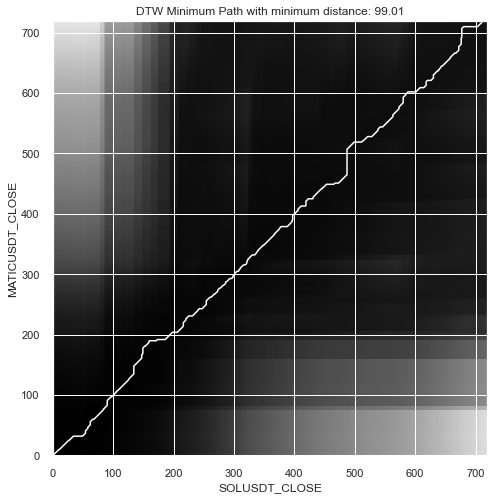

In [608]:
from dtw import dtw,accelerated_dtw

d1 = df_close['SOLUSDT_CLOSE_Norm'].interpolate().values
d2 = df_close['MATICUSDT_CLOSE_Norm'].interpolate().values

manhattan_distance = lambda d1, d2: np.abs(d1 - d2)

d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist=manhattan_distance)

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('SOLUSDT_CLOSE')
plt.ylabel('MATICUSDT_CLOSE')
plt.title(f'DTW Minimum Path with minimum distance: {np.round(d,2)}')
plt.show()

## RSI and Bollinger Bands

https://www.ta-lib.org/function.html  
https://towardsdatascience.com/trading-strategy-technical-analysis-with-python-ta-lib-3ce9d6ce5614  
https://github.com/mrjbq7/ta-lib  
https://mrjbq7.github.io/ta-lib/func_groups/momentum_indicators.html  
https://awesomeopensource.com/project/mrjbq7/ta-lib

https://www.investopedia.com/terms/r/rsi.asp

The relative strength index (RSI) is a momentum indicator used in technical analysis that measures the magnitude of recent price changes to evaluate overbought or oversold conditions in the price of a stock or other asset. The basic idea behind the RSI is to measure how quickly traders are bidding the price of the security up or down.  The RSI is displayed as an oscillator (a line graph that moves between two extremes) and can have a reading from 0 to 100. Traditional interpretation and usage of the RSI are that values of 70 or above indicate that a security is becoming overbought or overvalued and may be primed for a trend reversal or corrective pullback in price. An RSI reading of 30 or below indicates an oversold or undervalued condition.

The RSI will rise as the number and size of positive closes increase, and it will fall as the number and size of losses increase.

Many investors will apply a horizontal trendline between 30% and 70% levels when a strong trend is in place to better identify extremes. Modifying overbought or oversold levels when the price of a stock or asset is in a long-term horizontal channel is usually unnecessary. An oversold reading on the RSI in an uptrend is likely much higher than 30% and that an overbought reading on the RSI during a downtrend is much lower than the 70% level. ***Maybe adjusting the 30 & 70% standards based on Ian's "states" analysis??***

https://www.investopedia.com/trading/using-bollinger-bands-to-gauge-trends/

One of the more common calculations uses a 20-day simple moving average (SMA) for the middle band.
The upper band is calculated by taking the middle band and adding twice the daily standard deviation to that amount.
The lower band is calculated by taking the middle band minus two times the daily standard deviation.

When the price of the asset breaks below the lower band of the Bollinger Bands®, prices have perhaps fallen too much and are due to bounce. On the other hand, when price breaks above the upper band, the market is perhaps overbought and due for a pullback.

Using the bands as overbought/oversold indicators relies on the concept of mean reversion of the price. Mean reversion assumes that, if the price deviates substantially from the mean or average, it eventually reverts back to the mean price.

During a strong trend, for example, the trader runs the risk of placing trades on the wrong side of the move because the indicator can flash overbought or oversold signals too soon. To help remedy this, a trader can look at the overall direction of price and then ***only take trade signals that align the trader with the trend.***

***Perhaps a more useful way to trade with Bollinger Bands® is to use them to gauge trends.***

Whenever price holds between the upper Bollinger Bands® +1 SD and +2 SD away from mean, the trend is up; therefore, we can define that channel as the "buy zone." Conversely, if price channels within Bollinger Bands® –1 SD and –2 SD, it is in the "sell zone." Finally, if price meanders between +1 SD band and –1 SD band, it is essentially in a neutral state, and we can say that it's in uncharted territory.

https://stock-analysis-engine.readthedocs.io/en/latest/talib.html

BBANDS functions
Parameters:	
close – close prices
timeperiod – number of values (default is 5)
nbdevup – float - standard deviation to set the upper band (default is 2)
nbdevdn – float - standard deviation to set the lower band (default is 2)
matype – moving average type (default is 0 simple moving average)
verbose – show logs

In [712]:
# RSI
# up, mid, low of bollinger bands ... 2 standard deviations

price = df_pivot_filtered['BTCUSDT_CLOSE']
close = df_pivot_filtered['BTCUSDT_CLOSE'].values
up_2, mid_2, low_2 = BBANDS(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=20, nbdevup=2, nbdevdn=2, matype=MA_Type.T3)
rsi = RSI(close, timeperiod=14)
print("RSI (first 10 elements)\n", rsi[14:24])

RSI (first 10 elements)
 [27.85862786 35.51107934 32.9540468  29.96356231 29.32442541 33.09243707
 30.76802261 32.99804712 36.2163312  38.55063244]


In [713]:
# Creating dataframe for low Bollinger Band

df_low_2 = pd.DataFrame(low_2)
df_low_2.rename(columns = {0:'LOW_2'}, inplace = True)
df_low_2.reset_index(drop=True, inplace=True)
df_low_2.tail()

,LOW_2
4315,56512.664999
4316,56525.117875
4317,56526.114953
4318,56521.892062
4319,56529.262958


In [714]:
# Creating dataframe for middle Bollinger Band

df_mid = pd.DataFrame(mid)
df_mid.rename(columns = {0:'MID'}, inplace = True)
df_mid.reset_index(drop=True, inplace=True)
df_mid.tail()

,MID
4315,56733.302689
4316,56738.872758
4317,56745.063258
4318,56752.081202
4319,56759.829564


In [715]:
# Creating dataframe for upper Bollinger Band

df_up_2 = pd.DataFrame(up_2)
df_up_2.rename(columns = {0:'UP_2'}, inplace = True)
df_up_2.reset_index(drop=True, inplace=True)
df_up_2.tail()

,UP_2
4315,56953.940378
4316,56952.627641
4317,56964.011562
4318,56982.270342
4319,56990.396170


In [716]:
# Creating dataframe for RSI

df_rsi = pd.DataFrame(rsi)
df_rsi.rename(columns = {0:'RSI'}, inplace = True)
df_rsi.reset_index(drop=True, inplace=True)
df_rsi

,RSI
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,53.919075
4316,54.880426
4317,55.452343
4318,58.254138


In [717]:
# Reseting index to match prior dataframes.

df_pivot_filtered.reset_index(drop=True, inplace=True)

In [718]:
# up, mid, low of bollinger bands ... 1 standard deviation

price = df_pivot_filtered['BTCUSDT_CLOSE']
close = df_pivot_filtered['BTCUSDT_CLOSE'].values
up_1, mid_1, low_1 = BBANDS(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=20, nbdevup=1, nbdevdn=1, matype=MA_Type.T3)

In [719]:
# Creating dataframe for low Bollinger Band

df_low_1 = pd.DataFrame(low_1)
df_low_1.rename(columns = {0:'LOW_1'}, inplace = True)
df_low_1.reset_index(drop=True, inplace=True)
df_low_1.tail()

,LOW_1
4315,56622.983844
4316,56631.995316
4317,56635.589105
4318,56636.986632
4319,56644.546261


In [720]:
# Creating dataframe for upper Bollinger Band

df_up_1 = pd.DataFrame(up_1)
df_up_1.rename(columns = {0:'UP_1'}, inplace = True)
df_up_1.reset_index(drop=True, inplace=True)
df_up_1.tail()

,UP_1
4315,56843.621533
4316,56845.750199
4317,56854.537410
4318,56867.175772
4319,56875.112867


In [721]:
# Bringing together the RSI and BB dataframes.

df_rsi_bb = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'], df_pivot_filtered['BTCUSDT_CLOSE'], df_rsi['RSI'], df_low_2['LOW_2'], df_mid['MID'], df_up_2['UP_2'], df_low_1['LOW_1'], df_up_1['UP_1']], axis=1)
df_rsi_bb

,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1
0,2021-11-16 00:00:00,63432.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2021-11-16 00:01:00,63340.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2021-11-16 00:02:00,63228.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2021-11-16 00:03:00,63148.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2021-11-16 00:04:00,63091.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772


In [658]:
# def bbp(price):
#     up, mid, low = BBANDS(close, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
#     bbp = (price['AdjClose'] - low) / (up - low)
#     return bbp

In [722]:
# Calculating how far the price is from the lower band as a percent of how far the upper band is from the lower.

df_rsi_bb['BBP_2'] = (df_rsi_bb['BTCUSDT_CLOSE'] - df_rsi_bb['LOW_2']) / (df_rsi_bb['UP_2'] - df_rsi_bb['LOW_2'])
df_rsi_bb['BBP_1'] = (df_rsi_bb['BTCUSDT_CLOSE'] - df_rsi_bb['LOW_1']) / (df_rsi_bb['UP_1'] - df_rsi_bb['LOW_1'])

In [723]:
# Just having a look.

df_rsi_bb.tail()

,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533,0.753124,1.006248
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199,0.797367,1.094734
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410,0.803580,1.107160
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772,0.901667,1.303334
4319,2021-11-18 23:59:00,56892.0,55.392544,56529.262958,56759.829564,56990.396170,56644.546261,56875.112867,0.786621,1.073242


<AxesSubplot:xlabel='BBP_1', ylabel='Count'>

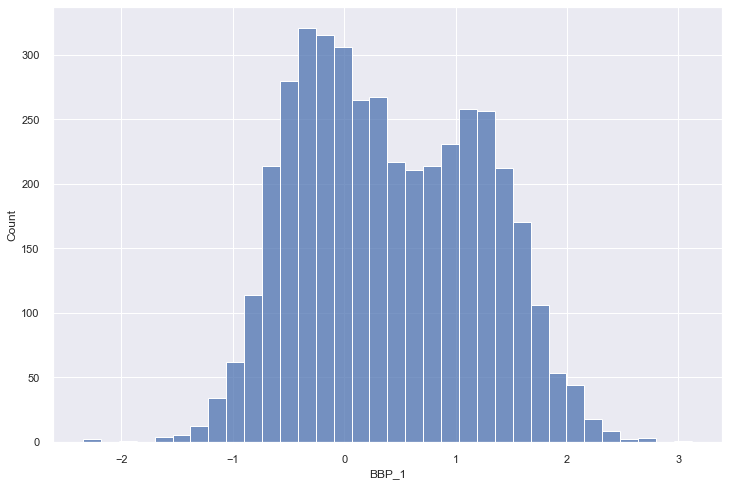

In [726]:
# Just having a look at the distribution of BBP.

sns.histplot(df_rsi_bb['BBP_1'])

<AxesSubplot:xlabel='RSI', ylabel='Count'>

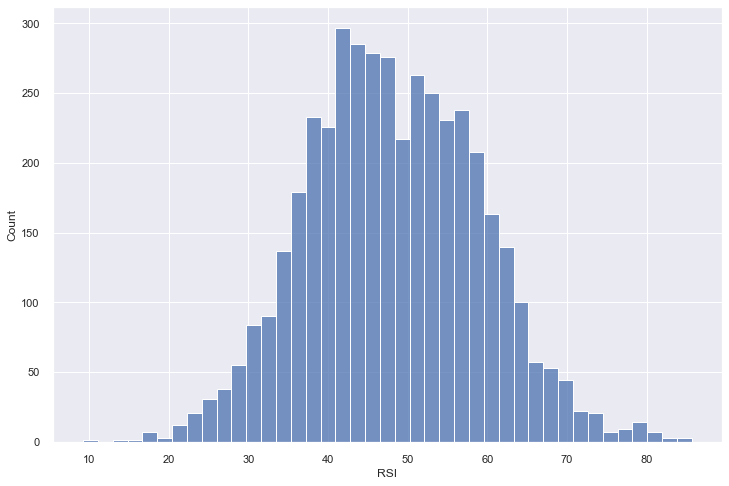

In [727]:
# Just having a look at the distribution of RSI.

sns.histplot(df_rsi_bb['RSI'])

In [767]:
# Creating rules that will display as red and green dots on the chart below.
# An asset is usually considered overbought when the RSI is above 70% and oversold when it is below 30%.

max_holding = 100

holdings = pd.DataFrame(index = df_rsi_bb.index, data={'Holdings': np.array([np.nan] * df_rsi_bb.index.shape[0])})
holdings.loc[((df_rsi_bb['RSI'] < 30) & (df_rsi_bb['BBP_2'] < 0)), 'Holdings'] = max_holding
holdings.loc[((df_rsi_bb['RSI'] > 70) & (df_rsi_bb['BBP_2'] > 1)), 'Holdings'] = 0
holdings.loc[((df_rsi_bb['RSI'] < 30) & (df_rsi_bb['BBP_1'] < 0)), 'Holdings'] = max_holding
holdings.loc[((df_rsi_bb['RSI'] > 70) & (df_rsi_bb['BBP_1'] > 1)), 'Holdings'] = 0
holdings.ffill(inplace=True)
holdings.fillna(0, inplace=True)

In [768]:
holdings['Holdings'].unique()

array([  0., 100.])

In [771]:
holdings['Order'] = holdings.diff()
holdings.fillna(0,inplace=True)

In [772]:
holdings.shape

(700, 2)

In [773]:
holdings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 700 entries, 3620 to 4319
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Holdings  700 non-null    float64
 1   Order     700 non-null    float64
dtypes: float64(2)
memory usage: 11.1 KB


In [774]:
index1 = holdings.index

In [775]:
index1

RangeIndex(start=3620, stop=4320, step=1)

In [776]:
index = index1.values

In [777]:
holdings1 = holdings.copy()

In [778]:
num = 700
holdings = holdings1.iloc[-num:]
index = index1[-num:]
df_rsi_bb = df_rsi_bb.iloc[-num:, :]

In [779]:
df_rsi_bb.tail()

,_OPEN_TIMESTAMP,BTCUSDT_CLOSE,RSI,LOW_2,MID,UP_2,LOW_1,UP_1,BBP_2,BBP_1
4315,2021-11-18 23:55:00,56845.0,53.919075,56512.664999,56733.302689,56953.940378,56622.983844,56843.621533,0.753124,1.006248
4316,2021-11-18 23:56:00,56866.0,54.880426,56525.117875,56738.872758,56952.627641,56631.995316,56845.750199,0.797367,1.094734
4317,2021-11-18 23:57:00,56878.0,55.452343,56526.114953,56745.063258,56964.011562,56635.589105,56854.537410,0.803580,1.107160
4318,2021-11-18 23:58:00,56937.0,58.254138,56521.892062,56752.081202,56982.270342,56636.986632,56867.175772,0.901667,1.303334
4319,2021-11-18 23:59:00,56892.0,55.392544,56529.262958,56759.829564,56990.396170,56644.546261,56875.112867,0.786621,1.073242


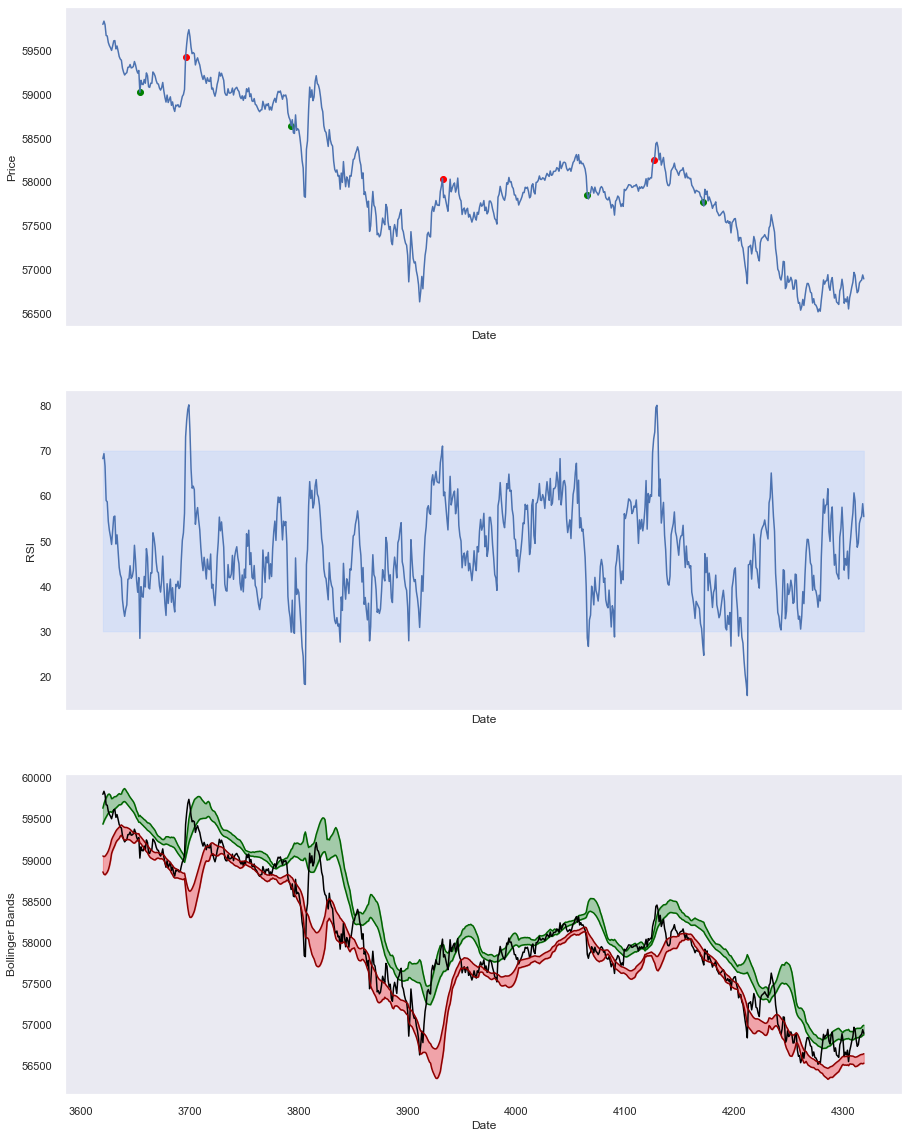

In [782]:
fig, (ax0, ax1, ax2) = plt.subplots(3, 1, sharex=True, figsize=(15, 20))
ax0.plot(index, df_rsi_bb['BTCUSDT_CLOSE'], label='Price')
ax0.set_xlabel('Date')
ax0.set_ylabel('Price')
ax0.grid()
for day, holding in holdings.iterrows():
    order = holding['Order']
    if order > 0:
        ax0.scatter(x=day, y=df_rsi_bb.loc[day, 'BTCUSDT_CLOSE'], color='green')
    elif order < 0:
        ax0.scatter(x=day, y=df_rsi_bb.loc[day, 'BTCUSDT_CLOSE'], color='red')

ax1.plot(index, df_rsi_bb['RSI'], label='RSI')
ax1.fill_between(index, y1=30, y2=70, color='#adccff', alpha=0.3)
ax1.set_xlabel('Date')
ax1.set_ylabel('RSI')
ax1.grid()

ax2.plot(index, df_rsi_bb['UP_2'], label='Up_2', color='darkgreen')
ax2.plot(index, df_rsi_bb['UP_1'], label='Up_1', color='darkgreen')
ax2.plot(index, df_rsi_bb['BTCUSDT_CLOSE'], label='Price', color='black')
ax2.plot(index, df_rsi_bb['LOW_1'], label='Low_1', color='darkred')
ax2.plot(index, df_rsi_bb['LOW_2'], label='Low_2', color='darkred')
ax2.fill_between(index, y1=df_rsi_bb['UP_1'], y2=df_rsi_bb['UP_2'], color='green', alpha=0.3)
ax2.fill_between(index, y1=df_rsi_bb['LOW_1'], y2=df_rsi_bb['LOW_2'], color='red', alpha=0.3)
ax2.set_xlabel('Date')
ax2.set_ylabel('Bollinger Bands')
ax2.grid()

# fig.tight_layout()
plt.show()

## Death / Golden Cross

In [823]:
# Calculate a simple moving average of the close prices

SMA_BTC_60 = pd.DataFrame(talib.SMA(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
SMA_BTC_60.rename(columns = {0:'SMA_BTC_60'}, inplace = True)
SMA_BTC_60.tail()

,SMA_BTC_60
4315,56728.766667
4316,56728.550000
4317,56728.583333
4318,56732.716667
4319,56737.366667


In [824]:
# Calculate a simple moving average of the close prices:

SMA_BTC_180 = pd.DataFrame(talib.SMA(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=180))
SMA_BTC_180.rename(columns = {0:'SMA_BTC_180'}, inplace = True)
SMA_BTC_180.tail()

,SMA_BTC_180
4315,57280.177778
4316,57272.950000
4317,57266.100000
4318,57260.166667
4319,57254.227778


In [825]:
# Merge dataframes.

SMA_BTC = pd.concat([df_pivot_filtered['_OPEN_TIMESTAMP'],SMA_BTC_60['SMA_BTC_60'], SMA_BTC_180['SMA_BTC_180']], axis=1)
SMA_BTC.shape

(4320, 3)

In [826]:
SMA_BTC['SMA_BTC_60'].fillna("0",inplace=True)
SMA_BTC['SMA_BTC_180'].fillna("0",inplace=True)
SMA_BTC.shape

(4320, 3)

In [827]:
SMA_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _OPEN_TIMESTAMP  4320 non-null   datetime64[ns]
 1   SMA_BTC_60       4320 non-null   object        
 2   SMA_BTC_180      4320 non-null   object        
dtypes: datetime64[ns](1), object(2)
memory usage: 101.4+ KB


In [828]:
SMA_BTC['SMA_BTC_60'] = SMA_BTC['SMA_BTC_60'].astype(float)
SMA_BTC['SMA_BTC_180'] = SMA_BTC['SMA_BTC_180'].astype(float)
SMA_BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4320 entries, 0 to 4319
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   _OPEN_TIMESTAMP  4320 non-null   datetime64[ns]
 1   SMA_BTC_60       4320 non-null   float64       
 2   SMA_BTC_180      4320 non-null   float64       
dtypes: datetime64[ns](1), float64(2)
memory usage: 101.4 KB


In [829]:
# Checking how many periods have increased momentum.

SMA_BTC["Cross_Num"] = (SMA_BTC["SMA_BTC_60"] > SMA_BTC["SMA_BTC_180"]).astype(int)
SMA_BTC.Cross_Num.sum()

1681

In [830]:
# Filtering to the most recent day.
num = 1440
SMA_BTC = SMA_BTC.iloc[-num:]
SMA_BTC.shape

(1440, 4)

In [831]:
# Just checking it out.

SMA_BTC.shape

(1440, 4)

In [832]:
# Set index as timestamp for easier access

SMA_BTC = SMA_BTC.set_index("_OPEN_TIMESTAMP")
SMA_BTC

,SMA_BTC_60,SMA_BTC_180,Cross_Num
_OPEN_TIMESTAMP,,,
2021-11-18 00:00:00,60066.633333,59981.588889,1
2021-11-18 00:01:00,60071.283333,59981.416667,1
2021-11-18 00:02:00,60073.850000,59980.611111,1
2021-11-18 00:03:00,60075.616667,59980.255556,1
2021-11-18 00:04:00,60077.133333,59980.133333,1
...,...,...,...
2021-11-18 23:55:00,56728.766667,57280.177778,0
2021-11-18 23:56:00,56728.550000,57272.950000,0
2021-11-18 23:57:00,56728.583333,57266.100000,0


In [833]:
SMA_BTC['Prior'] = SMA_BTC['Cross_Num'].shift()
SMA_BTC['Prior'].sum()

477.0

In [834]:
SMA_BTC['Signal_Buy'] = (SMA_BTC["Cross_Num"] == 1 ) & (SMA_BTC["Prior"] == 0)
print(SMA_BTC['Signal_Buy'].sum())
SMA_BTC['Signal_Sell'] = (SMA_BTC["Cross_Num"] == 0 ) & (SMA_BTC["Prior"] == 1)
print(SMA_BTC['Signal_Sell'].sum())
                     

3
4


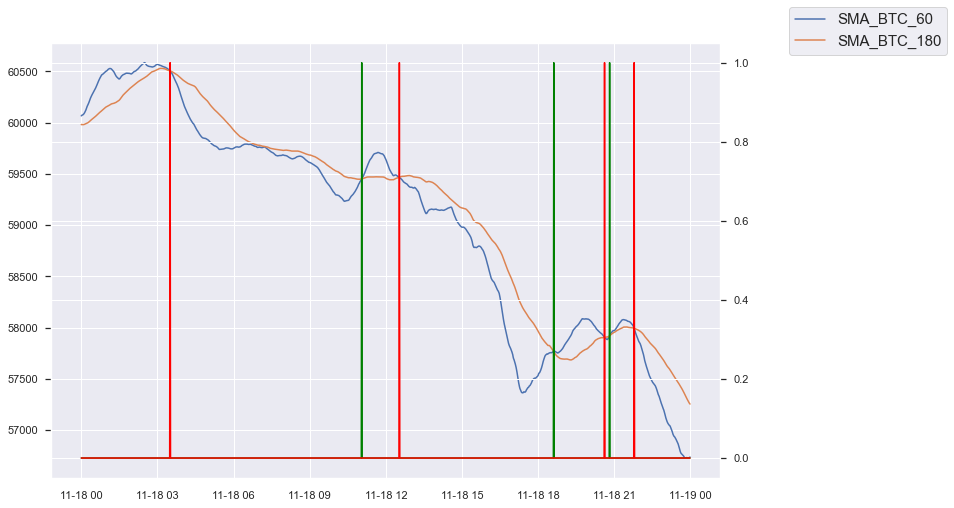

In [835]:
fig, ax = plt.subplots()
ax.plot(SMA_BTC["SMA_BTC_60"])
ax.plot(SMA_BTC["SMA_BTC_180"])

ax2=ax.twinx()
ax2.plot(SMA_BTC["Signal_Buy"], color = 'green')
ax2.plot(SMA_BTC["Signal_Sell"], color = 'red')

ax.legend(("SMA_BTC_60","SMA_BTC_180"), bbox_to_anchor=(1.35, 1.1), prop={'size': 15})
plt.show()

## Ta-lib Add'l TA

https://www.ta-lib.org/function.html  
https://awesomeopensource.com/project/mrjbq7/ta-lib  
https://mrjbq7.github.io/ta-lib/  
https://technical-analysis-library-in-python.readthedocs.io/en/latest/ta.html

In [838]:
print(talib.get_function_groups())

{'Cycle Indicators': ['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE'], 'Math Operators': ['ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM'], 'Math Transform': ['ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH'], 'Momentum Indicators': ['ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR'], 'Overlap Studies': ['BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA'], 'Pattern Recognition': ['CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHO

In [839]:
print(talib.get_functions())

['HT_DCPERIOD', 'HT_DCPHASE', 'HT_PHASOR', 'HT_SINE', 'HT_TRENDMODE', 'ADD', 'DIV', 'MAX', 'MAXINDEX', 'MIN', 'MININDEX', 'MINMAX', 'MINMAXINDEX', 'MULT', 'SUB', 'SUM', 'ACOS', 'ASIN', 'ATAN', 'CEIL', 'COS', 'COSH', 'EXP', 'FLOOR', 'LN', 'LOG10', 'SIN', 'SINH', 'SQRT', 'TAN', 'TANH', 'ADX', 'ADXR', 'APO', 'AROON', 'AROONOSC', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDEXT', 'MACDFIX', 'MFI', 'MINUS_DI', 'MINUS_DM', 'MOM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'STOCH', 'STOCHF', 'STOCHRSI', 'TRIX', 'ULTOSC', 'WILLR', 'BBANDS', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MAMA', 'MAVP', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'CDL2CROWS', 'CDL3BLACKCROWS', 'CDL3INSIDE', 'CDL3LINESTRIKE', 'CDL3OUTSIDE', 'CDL3STARSINSOUTH', 'CDL3WHITESOLDIERS', 'CDLABANDONEDBABY', 'CDLADVANCEBLOCK', 'CDLBELTHOLD', 'CDLBREAKAWAY', 'CDLCLOSINGMARUBOZU', 'CDLCONCEALBABYSWALL', 'CDLCOUNTERATTACK', 'CDLDARKCLOUDCOVER', 'CDLDOJI', 'CDLDOJISTAR',

---
***I can't figure out or find out how MOM is helpful...***

In [863]:
# Calculating momentum of the close prices

df_MOM = pd.DataFrame(talib.MOM(df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=5))
df_MOM.rename(columns = {0:'MOM_BTC'}, inplace=True)
df_MOM.reset_index(drop = True, inplace=True)
df_MOM

,MOM_BTC
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,-121.0
4316,-68.0
4317,63.0
4318,203.0


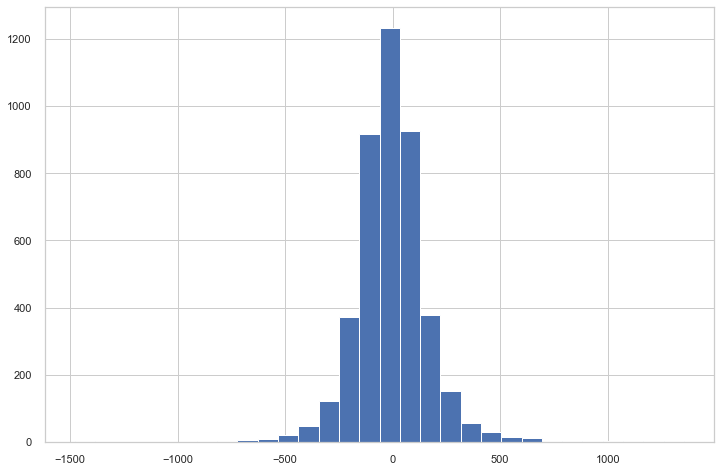

In [900]:
plt.hist(df_MOM, bins=30)
plt.show()

In [865]:
# Assembling low correlation coins

df_MOM_price = pd.concat([df_pivot_filtered, df_MOM], axis=1).reset_index(drop=True).drop_duplicates()
print(df_MOM_price.shape)
df_MOM_price.tail()

(4320, 86)


,_OPEN_TIMESTAMP,AVAXUSDT_CLOSE,BATUSDT_CLOSE,BTCUSDT_CLOSE,CHZUSDT_CLOSE,DOTUSDT_CLOSE,ENJUSDT_CLOSE,ETHUSDT_CLOSE,FTMUSDT_CLOSE,GALAUSDT_CLOSE,...,ENJUSDT_VOLUME,ETHUSDT_VOLUME,FTMUSDT_VOLUME,GALAUSDT_VOLUME,LINKUSDT_VOLUME,LRCUSDT_VOLUME,MANAUSDT_VOLUME,MATICUSDT_VOLUME,SOLUSDT_VOLUME,MOM_BTC
4315,2021-11-18 23:55:00,99.08,0.9736,56845.0,0.4293,38.88,3.00,3988.0,1.84,0.2311,...,20602.8,188.2945,168791.0,2590727.0,10522.32,26043.0,285141.0,63631.9,787.87,-121.0
4316,2021-11-18 23:56:00,99.39,0.9744,56866.0,0.4296,38.97,3.02,3992.0,1.84,0.2303,...,77247.0,160.4218,65825.0,822688.0,4037.30,15178.0,148136.0,86954.9,783.77,-68.0
4317,2021-11-18 23:57:00,99.70,0.9761,56878.0,0.4300,39.00,3.02,3994.0,1.85,0.2315,...,30169.1,218.0851,132444.0,2050754.0,2254.79,11380.0,222219.0,139101.3,756.34,63.0
4318,2021-11-18 23:58:00,100.14,0.9781,56937.0,0.4313,39.06,3.03,4001.0,1.85,0.2321,...,44447.8,266.5702,42566.0,745368.0,3626.33,37763.0,138243.0,26230.5,524.29,203.0
4319,2021-11-18 23:59:00,100.63,0.9781,56892.0,0.4298,39.03,3.04,3997.0,1.85,0.2288,...,54510.0,578.3948,58710.0,2033984.0,11614.19,63288.0,117158.0,45452.6,2501.90,138.0


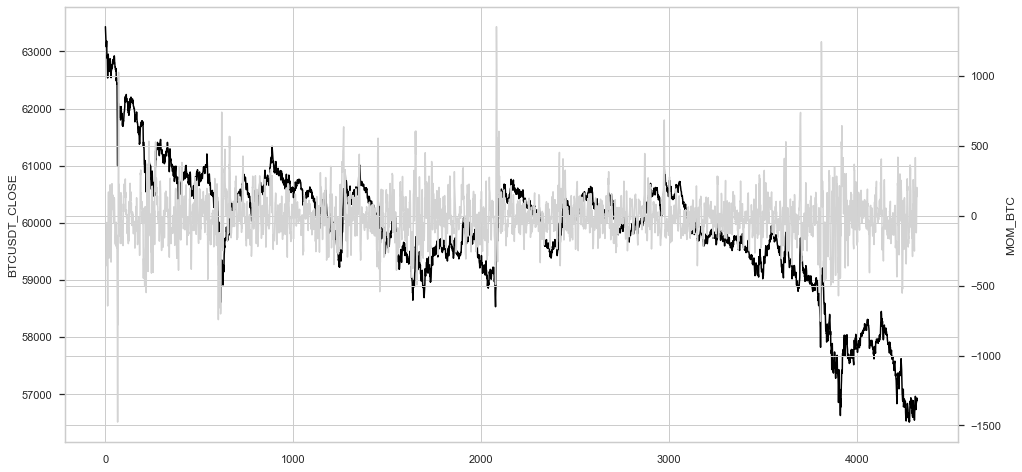

In [893]:
fig, ax1 = plt.subplots(figsize=(16,8))
sns.set_theme(style="whitegrid")

ax1 = sns.lineplot(data=df_MOM_price['BTCUSDT_CLOSE'], color='black')
ax2 = ax1.twinx()
ax2 = sns.lineplot(data=df_MOM_price['MOM_BTC'], color='lightgray')
plt.show()

---

***BETA***

In [922]:
# Calculating mean price across basket of coins.

df_pivot_filtered['avg_price'] = df_pivot_filtered[['AVAXUSDT_CLOSE','BATUSDT_CLOSE','BTCUSDT_CLOSE','CHZUSDT_CLOSE',
                                                    'DOTUSDT_CLOSE','ENJUSDT_CLOSE','ETHUSDT_CLOSE','FTMUSDT_CLOSE',
                                                   'GALAUSDT_CLOSE','LINKUSDT_CLOSE','LRCUSDT_CLOSE','MANAUSDT_CLOSE',
                                                   'MATICUSDT_CLOSE','SOLUSDT_CLOSE']].mean(axis=1)

In [924]:
# Calculating Beta against avg of all coins.

df_beta = pd.DataFrame(talib.BETA(df_pivot_filtered['avg_price'], df_pivot_filtered['ETHUSDT_CLOSE'], timeperiod=60))
df_beta.rename(columns = {0:'beta_avg_eth'}, inplace=True)
df_beta.reset_index(drop = True, inplace=True)
df_beta

,beta_avg_eth
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1.178401
4316,1.181253
4317,1.180147
4318,1.219809


---

***Direction Movement Index (DX)***

https://www.investopedia.com/terms/d/dmi.asp  
Identifies in which direction the price of an asset is moving. The indicator does this by comparing prior highs and lows and drawing two lines: a positive directional movement line (+DI) and a negative directional movement line (-DI). An optional third line, called the average directional index (ADX), can also be used to gauge the strength of the uptrend or downtrend.

When +DI is above -DI, there is more upward pressure than downward pressure in the price. Conversely, if -DI is above +DI, then there is more downward pressure on the price. This indicator may help traders assess the trend direction. Crossovers between the lines are also sometimes used as trade signals to buy or sell.

***KEY TAKEAWAYS***  
The directional movement index (DMI) is a technical indicator that measures both the strength and direction of a price movement and is intended to reduce false signals.  
The DMI utilizes two standard indicators, one negative (-DM) and one positive (+DN), in conjunction with a third, the average directional index (ADX), which is non-directional but shows momentum.  
The larger the spread between the two primary lines, the stronger the price trend. If +DI is way above -DI the price trend is strongly up. If -DI is way above +DI then the price trend is strongly down.  ADX measures the strength of the trend, either up or down; a reading above 25 indicates a strong trend.

Crossovers are the main trade signals. A long trade is taken when the +DI crosses above the -DI and an uptrend could be underway. Meanwhile, a sell signal occurs when the +DI instead crosses below the -DI

In [952]:
# Calculating Directional Movement Index (DX)

df_dx = pd.DataFrame(talib.DX(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
df_dx.rename(columns = {0:'dx_btc'}, inplace=True)
df_dx.reset_index(drop = True, inplace=True)
df_dx

,dx_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,3.981594
4316,3.270230
4317,2.259390
4318,2.259390


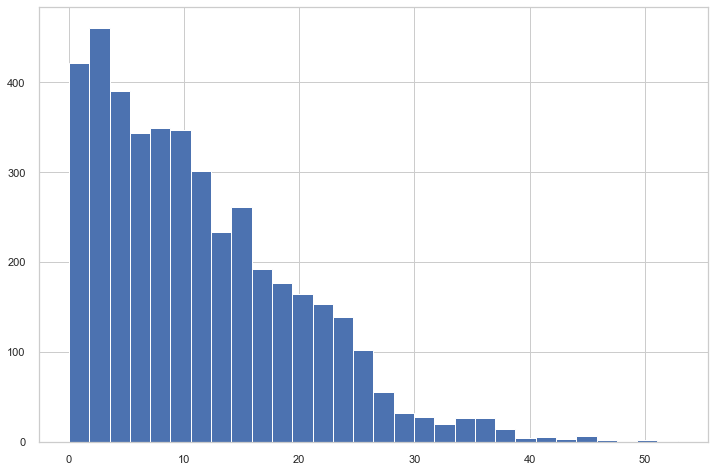

In [953]:
plt.hist(df_dx, bins=30)
plt.show()

In [940]:
# Calculating Average Directional Movement Index (ADX)

df_adx = pd.DataFrame(talib.ADX(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], df_pivot_filtered['BTCUSDT_CLOSE'], timeperiod=60))
df_adx.rename(columns = {0:'adx_btc'}, inplace=True)
df_adx.reset_index(drop = True, inplace=True)
df_adx

,adx_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,12.124315
4316,11.976747
4317,11.814791
4318,11.655534


In [950]:
# Calculating Minus Directional Indicator (-DI)

df_adx_neg = pd.DataFrame(talib.MINUS_DM(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], timeperiod=60))
df_adx_neg.rename(columns = {0:'adx_neg_btc'}, inplace=True)
df_adx_neg.reset_index(drop = True, inplace=True)
df_adx_neg

,adx_neg_btc
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1900.465062
4316,1868.790644
4317,1837.644134
4318,1807.016731


In [951]:
# Calculating Positive Directional Indicator (+DI)

df_dx_pos = pd.DataFrame(talib.PLUS_DM(df_pivot_filtered['BTCUSDT_HIGH'], df_pivot_filtered['BTCUSDT_LOW'], timeperiod=60))
df_dx_pos.rename(columns = {0:'dx_btc_pos'}, inplace=True)
df_dx_pos.reset_index(drop = True, inplace=True)
df_dx_pos

,dx_btc_pos
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN
...,...
4315,1754.922375
4316,1750.433669
4317,1756.439775
4318,1727.165778


Max Facts : tax advantage for holding over a year, listed as a trader gets an advantage